# Create Ross Ice Shelf starting bathymetry

Use bedmachine bed data outside of the the RIS, and interpolated RIGGS seismic depths from within the ice shelf.

In [1]:
from __future__ import annotations

%load_ext autoreload
%autoreload 2

import os
import string

import geopandas as gpd
import numpy as np
import pandas as pd
import pygmt
import pyogrio
import verde as vd
import xarray as xr
import zarr
from polartoolkit import fetch, maps, profiles, regions
from polartoolkit import utils as polar_utils

import RIS_gravity_inversion.utils as RIS_utils

os.environ["POLARTOOLKIT_HEMISPHERE"] = "south"

from invert4geom import uncertainty, utils

# Set region and parameters

In [2]:
starting_region = [-580e3, 420e3, -1420e3, -420e3]

inversion_region = starting_region
buffer_region = vd.pad_region(starting_region, 40e3)

# set layer parameters
layer_spacing = 5e3
registration = "g"

print(f"layer spacing: {layer_spacing}m")
print(f"registration: {registration}")
print("inversion region = ", inversion_region)
print("buffer region = ", buffer_region)

layer spacing: 5000.0m
registration: g
inversion region =  [-580000.0, 420000.0, -1420000.0, -420000.0]
buffer region =  (-620000.0, 460000.0, -1460000.0, -380000.0)


# Load data

### Get Bedmachine v3 data

In [4]:
# surface
fname = "../../inversion_layers/bedmachine_surface.zarr"
bedmachine_surface_full = xr.open_zarr(fname).surface
# icebase
fname = "../../inversion_layers/bedmachine_icebase.zarr"
bedmachine_icebase_full = xr.open_zarr(fname).icebase
# bed
fname = "../../inversion_layers/bedmachine_bed.zarr"
bedmachine_bed_full = xr.open_zarr(fname).bed

bedmachine_bed_error = xr.open_zarr("../../inversion_layers/bedmachine_bed_error.zarr")[
    "bed_error"
]

# resample bedmachine data at new spacing
bedmachine_surface_1k = fetch.resample_grid(
    bedmachine_surface_full,
    spacing=1e3,
    registration=registration,
    region=buffer_region,
    verbose="q",
).rename({"x": "easting", "y": "northing"})
bedmachine_icebase_1k = fetch.resample_grid(
    bedmachine_icebase_full,
    spacing=1e3,
    registration=registration,
    region=buffer_region,
    verbose="q",
).rename({"x": "easting", "y": "northing"})
bedmachine_bed_1k = fetch.resample_grid(
    bedmachine_bed_full,
    spacing=1e3,
    registration=registration,
    region=buffer_region,
    verbose="q",
).rename({"x": "easting", "y": "northing"})

# resample bedmachine data at layer spacing
bedmachine_surface_layer_spacing = fetch.resample_grid(
    bedmachine_surface_full,
    spacing=layer_spacing,
    region=buffer_region,
    registration=registration,
    verbose="q",
).rename({"x": "easting", "y": "northing"})
bedmachine_icebase_layer_spacing = fetch.resample_grid(
    bedmachine_icebase_full,
    spacing=layer_spacing,
    region=buffer_region,
    registration=registration,
    verbose="q",
).rename({"x": "easting", "y": "northing"})
bedmachine_bed_layer_spacing = fetch.resample_grid(
    bedmachine_bed_full,
    spacing=layer_spacing,
    region=buffer_region,
    registration=registration,
    verbose="q",
).rename({"x": "easting", "y": "northing"})

# ensure layers never cross
bedmachine_icebase_layer_spacing = xr.where(
    bedmachine_icebase_layer_spacing > bedmachine_surface_layer_spacing,
    bedmachine_surface_layer_spacing,
    bedmachine_icebase_layer_spacing,
)

### Get Bedmap2 data

In [5]:
# surface
fname = "../../inversion_layers/bedmap2_surface.zarr"
bedmap2_surface_full = xr.open_zarr(fname).surface
# icebase
fname = "../../inversion_layers/bedmap2_icebase.zarr"
bedmap2_icebase_full = xr.open_zarr(fname).icebase
# bed
fname = "../../inversion_layers/bedmap2_bed.zarr"  # w.r.t. ellipsoid
bedmap2_bed_full = xr.open_zarr(fname).bed

# resample bedmap2 data at new spacing
bedmap2_surface_1k = fetch.resample_grid(
    bedmap2_surface_full,
    spacing=1e3,
    registration=registration,
    region=buffer_region,
    verbose="q",
).rename({"x": "easting", "y": "northing"})
bedmap2_icebase_1k = fetch.resample_grid(
    bedmap2_icebase_full,
    spacing=1e3,
    registration=registration,
    region=buffer_region,
    verbose="q",
).rename({"x": "easting", "y": "northing"})
bedmap2_bed_1k = fetch.resample_grid(
    bedmap2_bed_full,
    spacing=1e3,
    registration=registration,
    region=buffer_region,
    verbose="q",
).rename({"x": "easting", "y": "northing"})

# resample bedmachine data at layer spacing
bedmap2_surface_layer_spacing = fetch.resample_grid(
    bedmap2_surface_full,
    spacing=layer_spacing,
    region=buffer_region,
    registration=registration,
    verbose="q",
).rename({"x": "easting", "y": "northing"})
bedmap2_icebase_layer_spacing = fetch.resample_grid(
    bedmap2_icebase_full,
    spacing=layer_spacing,
    region=buffer_region,
    registration=registration,
    verbose="q",
).rename({"x": "easting", "y": "northing"})
bedmap2_bed_layer_spacing = fetch.resample_grid(
    bedmap2_bed_full,
    spacing=layer_spacing,
    region=buffer_region,
    registration=registration,
    verbose="q",
).rename({"x": "easting", "y": "northing"})

# ensure layers never cross
bedmap2_icebase_layer_spacing = xr.where(
    bedmap2_icebase_layer_spacing > bedmap2_surface_layer_spacing,
    bedmap2_surface_layer_spacing,
    bedmap2_icebase_layer_spacing,
)

# Method 1: fit spline to just data near NaN's, merge to bedmachine

## get RIS seismic depths

In [6]:
# fname = RIS_utils.fetch_private_github_file(
#     "bedmap1.csv.gz",
#     fpath="RIS_grav_bath_data/main/processing",
#     output_dir="../../data",
# )

In [7]:
fname = "../../data/bedmap1.csv.gz"

RIS_points = pd.read_csv(
    fname,
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)

RIS_points = RIS_points.rename(
    columns={"x": "easting", "y": "northing", "z_ellipsoidal": "upward"}
)

RIS_points["inside"] = True

print(f"bathymetry control points:{len(RIS_points)}")
RIS_points.describe()

bathymetry control points:2098


easting      northing          lat          lon   station_ID  \
count    2098.000000  2.098000e+03  2098.000000  2098.000000  2098.000000   
mean    67748.686326 -5.616066e+05   -84.087043    78.937321    37.362250   
std    287769.205920  2.336858e+05     1.914483   130.227769    11.822658   
min   -677461.485401 -1.338933e+06   -86.731670  -179.819200     1.000000   
25%    -65360.134557 -6.437994e+05   -85.233153  -120.581100    43.000000   
50%    217121.984444 -5.040471e+05   -84.616500   149.687900    43.000000   
75%    258741.629376 -3.776139e+05   -83.807600   160.493200    43.000000   
max    465329.408780 -3.100916e+05   -77.656670   179.950300    44.000000   

            upward  z_geoidal  z_error  measurement_type  
count  2098.000000        0.0      0.0               0.0  
mean    206.901811        NaN      NaN               NaN  
std     695.361931        NaN      NaN               NaN  
min   -1461.000000        NaN      NaN               NaN  
25%    -477.000000        NaN      NaN               NaN  
50%     351.000000        NaN      NaN               NaN  
75%     725.500000        NaN      NaN               NaN  
max    1980.000000        NaN      NaN               NaN

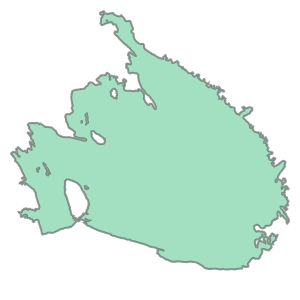

In [8]:
RIS_outline = pyogrio.read_dataframe("../../plotting/RIS_outline.shp")
RIS_outline.geometry[0]

In [9]:
# get points within RIS
gdf = gpd.GeoDataFrame(
    RIS_points,
    geometry=gpd.points_from_xy(x=RIS_points.easting, y=RIS_points.northing),
    crs="EPSG:3031",
)
RIS_points["inside"] = gdf.within(RIS_outline.geometry[0])

RIS_points = RIS_points[RIS_points["inside"]]
RIS_points.describe()

easting      northing         lat         lon  station_ID  \
count     223.000000  2.230000e+02  223.000000  223.000000  223.000000   
mean   -68866.120591 -1.019148e+06  -80.352235   -9.656647   13.699552   
std    250718.371845  1.798082e+05    1.687297  168.173939    8.608311   
min   -552131.657413 -1.338933e+06  -84.600000 -179.819200    1.000000   
25%   -272862.377514 -1.156648e+06  -81.603470 -165.579050    1.000000   
50%    -52178.399561 -1.037217e+06  -79.976110 -154.674400   19.000000   
75%    159939.301858 -8.784096e+05  -79.044165  170.377200   19.000000   
max    370320.590763 -5.637318e+05  -77.656670  179.950300   25.000000   

            upward  z_geoidal  z_error  measurement_type  
count   223.000000        0.0      0.0               0.0  
mean   -676.533632        NaN      NaN               NaN  
std     161.808745        NaN      NaN               NaN  
min   -1397.000000        NaN      NaN               NaN  
25%    -750.000000        NaN      NaN               NaN  
50%    -676.000000        NaN      NaN               NaN  
75%    -564.000000        NaN      NaN               NaN  
max    -354.000000        NaN      NaN               NaN

In [10]:
RIS_points = profiles.sample_grids(
    RIS_points,
    bedmap2_bed_full,
    sampled_name="bedmap2",
    coord_names=["easting", "northing"],
)

RIS_points["dif"] = RIS_points.bedmap2 - RIS_points.upward

print("RMS Difference with bedmap2: ", utils.rmse(RIS_points.dif))

RIS_points.sort_values(by="dif").describe()

RMS Difference with bedmap2:  130.22201223363626


easting      northing         lat         lon  station_ID  \
count     223.000000  2.230000e+02  223.000000  223.000000  223.000000   
mean   -68866.120591 -1.019148e+06  -80.352235   -9.656647   13.699552   
std    250718.371845  1.798082e+05    1.687297  168.173939    8.608311   
min   -552131.657413 -1.338933e+06  -84.600000 -179.819200    1.000000   
25%   -272862.377514 -1.156648e+06  -81.603470 -165.579050    1.000000   
50%    -52178.399561 -1.037217e+06  -79.976110 -154.674400   19.000000   
75%    159939.301858 -8.784096e+05  -79.044165  170.377200   19.000000   
max    370320.590763 -5.637318e+05  -77.656670  179.950300   25.000000   

            upward  z_geoidal  z_error  measurement_type      bedmap2  \
count   223.000000        0.0      0.0               0.0   223.000000   
mean   -676.533632        NaN      NaN               NaN  -680.545572   
std     161.808745        NaN      NaN               NaN   178.955753   
min   -1397.000000        NaN      NaN               NaN -1333.559711   
25%    -750.000000        NaN      NaN               NaN  -778.338647   
50%    -676.000000        NaN      NaN               NaN  -684.369629   
75%    -564.000000        NaN      NaN               NaN  -589.933758   
max    -354.000000        NaN      NaN               NaN   -91.307901   

              dif  
count  223.000000  
mean    -4.011939  
std    130.453021  
min   -204.421561  
25%    -57.538232  
50%    -46.900038  
75%    -15.301155  
max    734.495445

makecpt [WARNING]: Without inc in -T option, -Z has no effect (ignored)


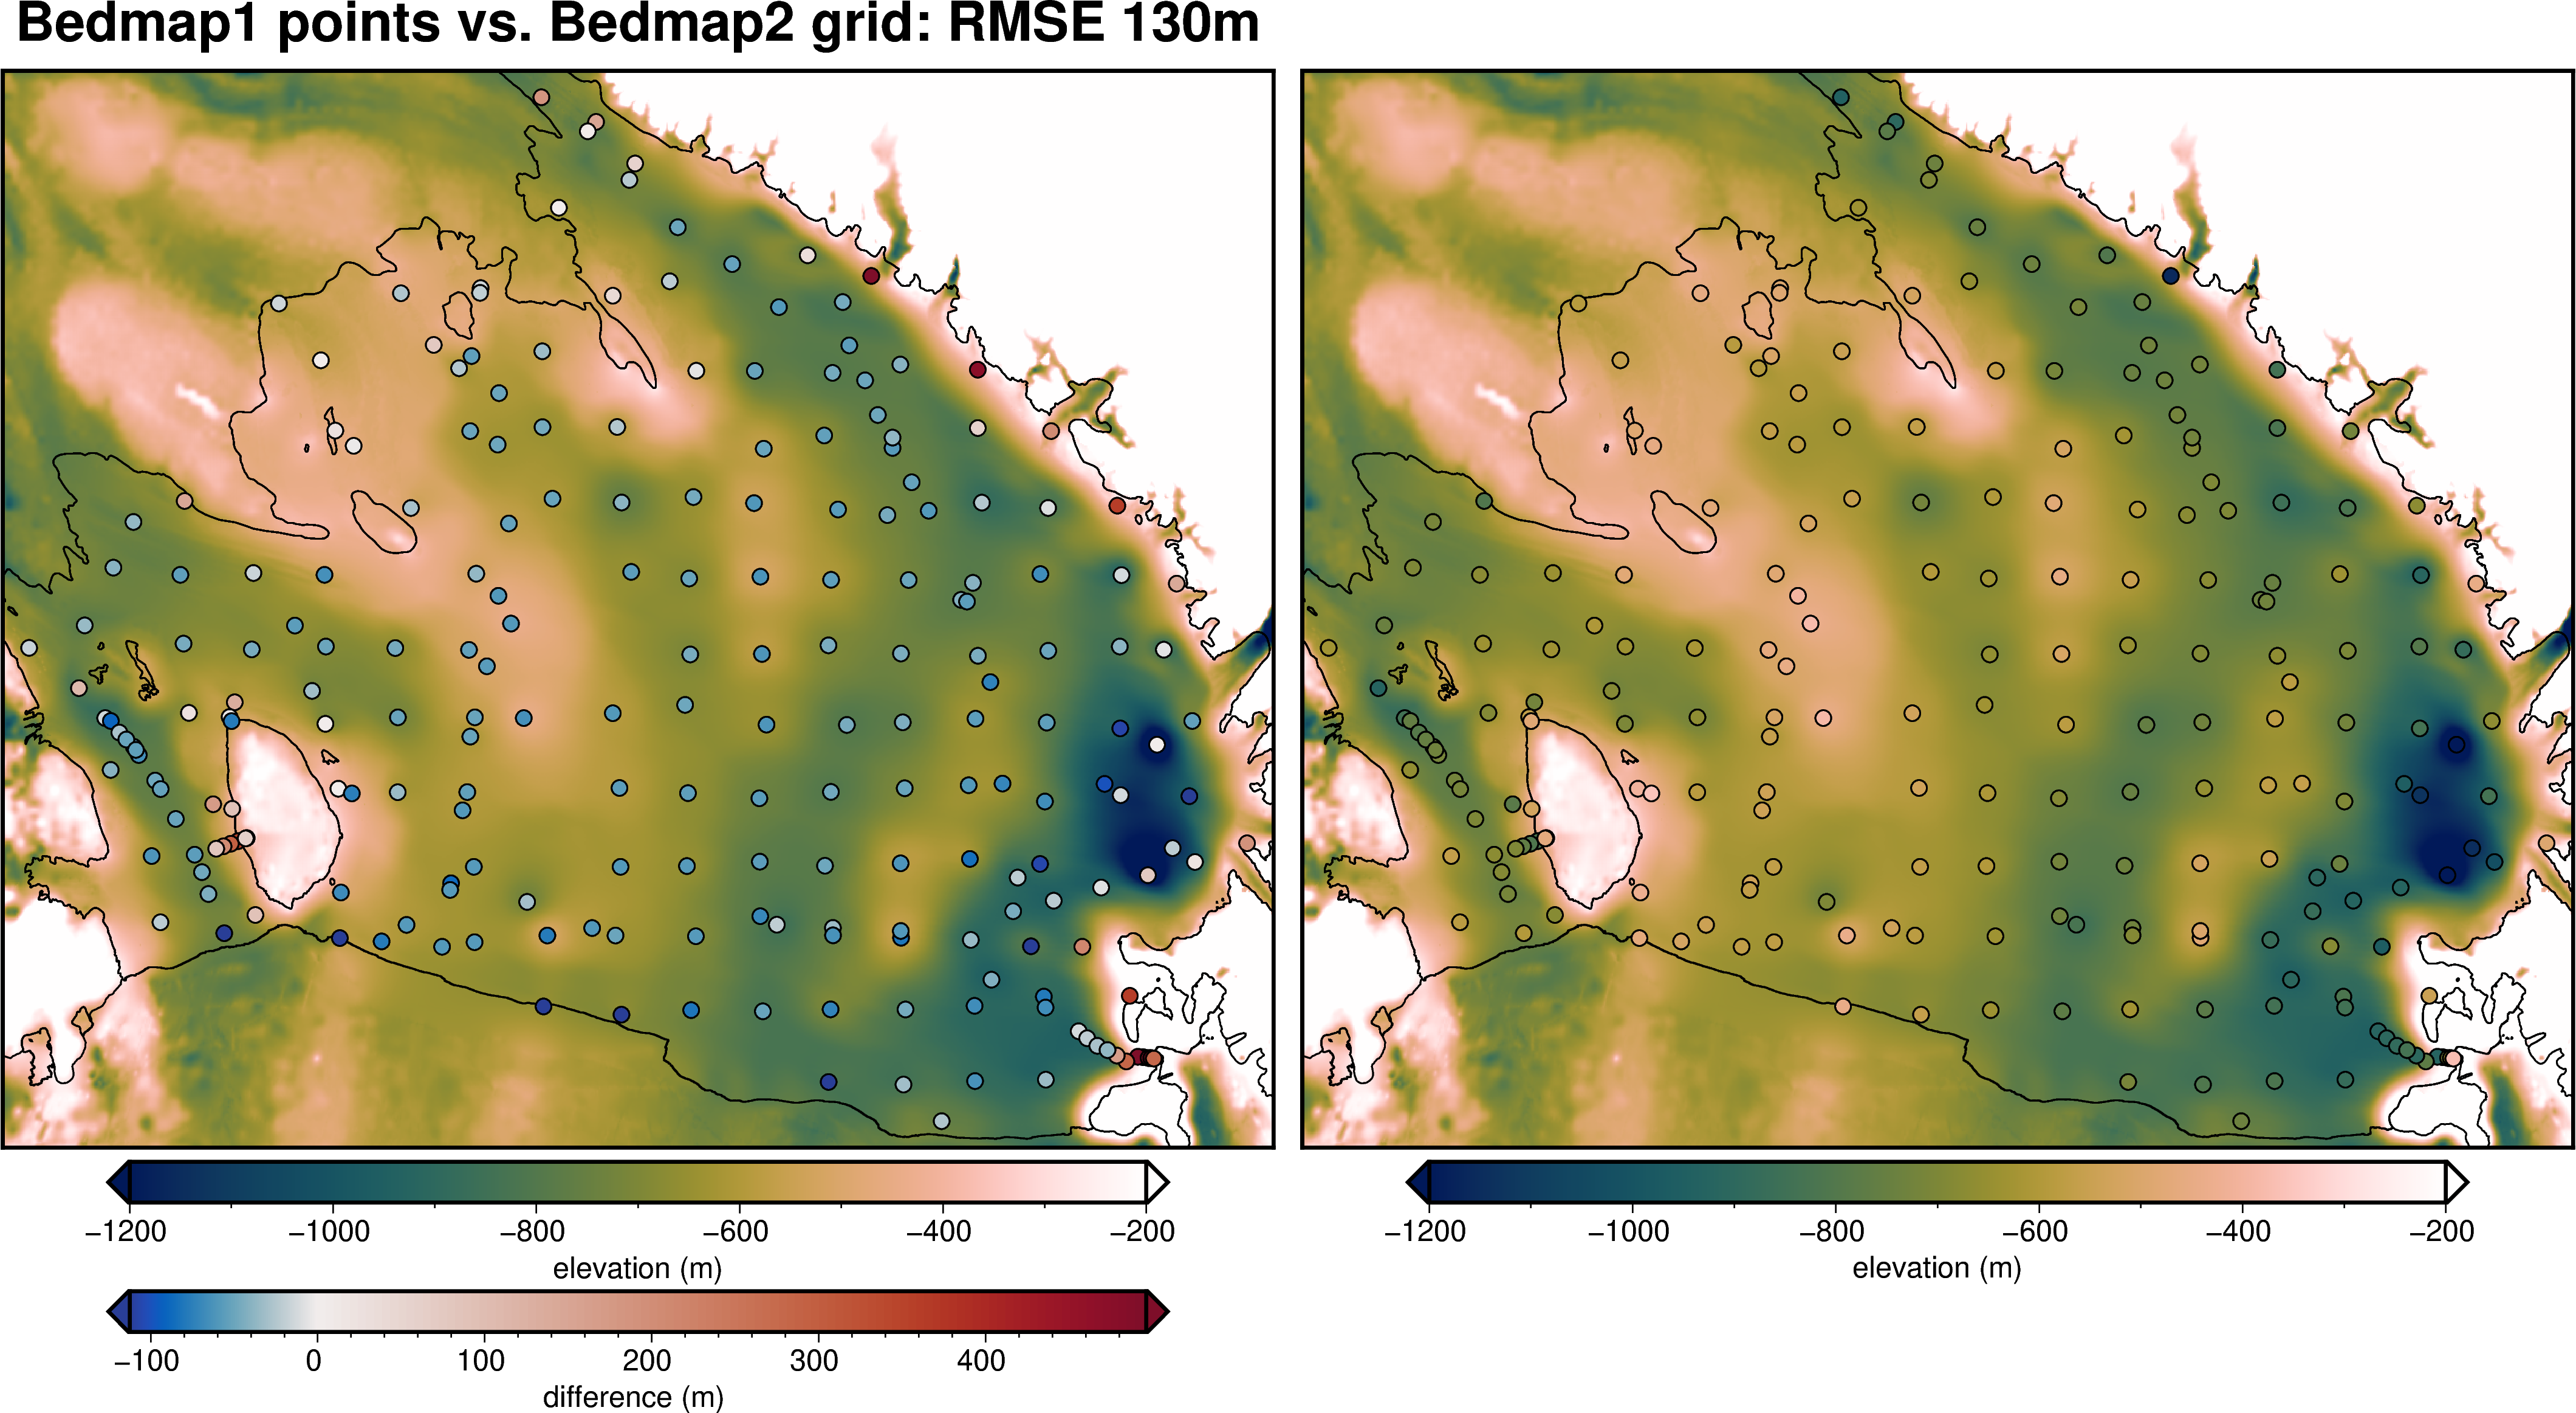

In [11]:
rmse = int(utils.rmse(RIS_points.dif))
fig = maps.plot_grd(
    bedmap2_bed_full,
    cmap="batlowW",
    cpt_lims=[-1200, -200],
    region=vd.pad_region(
        vd.get_region((RIS_points.easting, RIS_points.northing)), 20e3
    ),
    coast=True,
    title=f"Bedmap1 points vs. Bedmap2 grid: RMSE {rmse}m",
    cbar_label="elevation (m)",
)

lims = polar_utils.get_min_max(RIS_points.dif, robust=True)

# make colorscale
pygmt.makecpt(
    cmap="balance+h0",
    truncate=[-0.8, 0.8],
    series=lims,
    background="o",
    continuous=True,
)

# plot data
fig.plot(
    x=RIS_points.easting,
    y=RIS_points.northing,
    fill=RIS_points.dif,
    style="c.22c",
    pen=".6p,black",
    cmap=True,
)

maps.add_colorbar(fig, cbar_yoffset=2, cbar_label="difference (m) ")


fig = maps.plot_grd(
    bedmap2_bed_full,
    cmap="batlowW",
    cpt_lims=[-1200, -200],
    region=vd.pad_region(
        vd.get_region((RIS_points.easting, RIS_points.northing)), 20e3
    ),
    coast=True,
    cbar_label="elevation (m)",
    fig=fig,
    origin_shift="xshift",
)

# plot data
fig.plot(
    x=RIS_points.easting,
    y=RIS_points.northing,
    fill=RIS_points.upward,
    style="c.22c",
    pen=".6p,black",
    cmap=True,
)

fig.show()

In [ ]:
RIS_points = RIS_points.drop(columns=["dif", "bedmap2"])

In [13]:
# get RIS area
RIS_area = RIS_outline.area.values[0] / 10**6

print(f"ice shelf area: {round(RIS_area)} km\u00b2")
print(
    "Ross Ice Shelf constraint density: 1 constraint per "
    f"{int(RIS_area / len(RIS_points))} km\u00b2"
)

ice shelf area: 480428 km²
Ross Ice Shelf constraint density: 1 constraint per 2154 km²


## give inside points an uncertainty of 5% depth from surface

In [14]:
# sample ice surface elevation into dataframe
# from bedmachine,
RIS_points = profiles.sample_grids(
    RIS_points,
    bedmachine_surface_full,
    "surface_z_ellipsoidal",
    coord_names=["easting", "northing"],
)

# calculate error as 5% of depth from surface
depth = RIS_points.surface_z_ellipsoidal - RIS_points.upward
uncert = 0.05 * depth

RIS_points.loc[RIS_points.index, "uncert"] = uncert


print(f"mean uncertainty inside RIS: {np.nanmean(RIS_points.uncert)} m")

RIS_points.describe()

mean uncertainty inside RIS: 33.46187182789685 m


easting      northing         lat         lon  station_ID  \
count     223.000000  2.230000e+02  223.000000  223.000000  223.000000   
mean   -68866.120591 -1.019148e+06  -80.352235   -9.656647   13.699552   
std    250718.371845  1.798082e+05    1.687297  168.173939    8.608311   
min   -552131.657413 -1.338933e+06  -84.600000 -179.819200    1.000000   
25%   -272862.377514 -1.156648e+06  -81.603470 -165.579050    1.000000   
50%    -52178.399561 -1.037217e+06  -79.976110 -154.674400   19.000000   
75%    159939.301858 -8.784096e+05  -79.044165  170.377200   19.000000   
max    370320.590763 -5.637318e+05  -77.656670  179.950300   25.000000   

            upward  z_geoidal  z_error  measurement_type  \
count   223.000000        0.0      0.0               0.0   
mean   -676.533632        NaN      NaN               NaN   
std     161.808745        NaN      NaN               NaN   
min   -1397.000000        NaN      NaN               NaN   
25%    -750.000000        NaN      NaN               NaN   
50%    -676.000000        NaN      NaN               NaN   
75%    -564.000000        NaN      NaN               NaN   
max    -354.000000        NaN      NaN               NaN   

       surface_z_ellipsoidal      uncert  
count             223.000000  223.000000  
mean               -7.296196   33.461872  
std                16.833960    8.213173  
min               -55.000000   15.855000  
25%               -16.070832   27.687480  
50%               -10.411900   33.328525  
75%                 3.025650   37.486315  
max                51.118634   69.763951

## make mask of buffer ice shelf border

## Make constraint points dataframe

Ross Ice Shelf sparse constraints inside ice shelf, and gridded Bedmachine bed outside of ice shelf at 5km cell size.

In [ ]:
# regrid bed data at spacing
bed = fetch.resample_grid(
    bedmachine_bed_full,
    # bedmap2_bed_full,
    spacing=layer_spacing,
    registration=registration,
    region=buffer_region,
)

# bed_error = fetch.resample_grid(
#     bedmachine_bed_error,
#     spacing=layer_spacing,
#     registration=registration,
#     region=region,
# )

# get grid points outside of RIS
_, outside_points, _ = RIS_utils.get_buffer_points(
    buffer_width=layer_spacing,
    grid=bed,
    mask=RIS_outline,
    # plot = True,
)

outside_points = outside_points.rename(columns={"x": "easting", "y": "northing"})

# label outside points and set error
outside_points["inside"] = False
outside_points["uncert"] = 10

# merge outside and inside points
outside_and_inside_points = pd.concat((outside_points, RIS_points))

outside_and_inside_points.describe()

# set weighting values
outside_and_inside_points["weights"] = 1 / (outside_and_inside_points.uncert**2)

outside_and_inside_points = outside_and_inside_points.drop(
    columns=outside_and_inside_points.columns.difference(
        ["northing", "easting", "upward", "uncert", "inside", "weights"]
    ),
)

constraints = outside_and_inside_points.copy()

# save constraints to csv
constraints.to_csv(
    "../../data/bed_constraints.csv.gz",
    sep=",",
    na_rep="",
    header=True,
    index=False,
    encoding="utf-8",
    compression="gzip",
)

constraints.describe()

grdsample [WARNING]: Output sampling interval in x exceeds input interval and may lead to aliasing.
grdsample [WARNING]: Output sampling interval in y exceeds input interval and may lead to aliasing.


northing        easting        upward        uncert       weights
count  2.808700e+04   28087.000000  28087.000000  28087.000000  28087.000000
mean  -8.756051e+05  -90456.515288    -36.562229     10.186278      0.009929
std    3.686328e+05  357858.552976   1011.730342      2.206600      0.000795
min   -1.460000e+06 -620000.000000  -3684.734619     10.000000      0.000205
25%   -1.280917e+06 -425000.000000   -653.141785     10.000000      0.010000
50%   -7.550000e+05 -120000.000000   -456.224335     10.000000      0.010000
75%   -5.450000e+05  270000.000000    554.251190     10.000000      0.010000
max   -3.800000e+05  460000.000000   4053.679443     69.763951      0.010000

## interpolate inside and buffer zone points
necessary to seperate from outside points since they are already gridded and interpolating with than many points is unfeasable

northing        easting       upward       uncert         lat  \
count  1.476000e+03    1476.000000  1476.000000  1476.000000  223.000000   
mean  -9.494613e+05  -95987.225536  -437.128610    13.544714  -80.352235   
std    2.486565e+05  304792.671707   388.185254     8.988950    1.687297   
min   -1.360000e+06 -595000.000000 -2170.211914    10.000000  -84.600000   
25%   -1.175000e+06 -360000.000000  -698.250000    10.000000  -81.603470   
50%   -9.550000e+05 -155000.000000  -519.522034    10.000000  -79.976110   
75%   -7.350000e+05  207451.339868  -294.661034    10.000000  -79.044165   
max   -4.300000e+05  400000.000000  1251.222778    69.763951  -77.656670   

              lon  station_ID  z_geoidal  z_error  measurement_type  \
count  223.000000  223.000000        0.0      0.0               0.0   
mean    -9.656647   13.699552        NaN      NaN               NaN   
std    168.173939    8.608311        NaN      NaN               NaN   
min   -179.819200    1.000000        NaN      NaN               NaN   
25%   -165.579050    1.000000        NaN      NaN               NaN   
50%   -154.674400   19.000000        NaN      NaN               NaN   
75%    170.377200   19.000000        NaN      NaN               NaN   
max    179.950300   25.000000        NaN      NaN               NaN   

       surface_z_ellipsoidal      weights  
count             223.000000  1476.000000  
mean               -7.296196     0.008650  
std                16.833960     0.003208  
min               -55.000000     0.000205  
25%               -16.070832     0.010000  
50%               -10.411900     0.010000  
75%                 3.025650     0.010000  
max                51.118634     0.010000

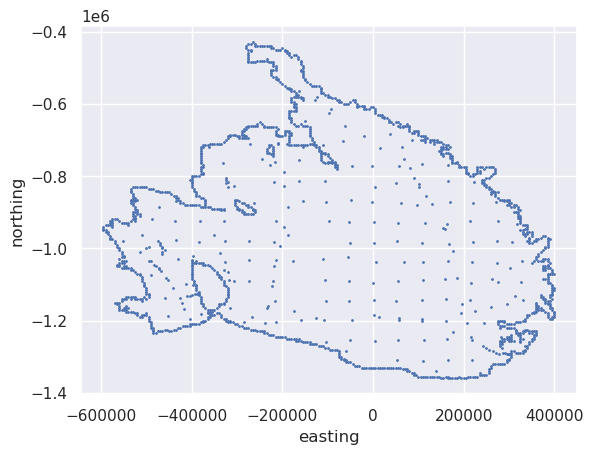

In [19]:
# new_spacing = 1e3

# get buffered border and grid with inside RIS masked
buffer_points, _, bed_outside = RIS_utils.get_buffer_points(
    buffer_width=layer_spacing,
    grid=bedmachine_bed_layer_spacing,
    mask=RIS_outline,
    # plot = True,
)

# label outside points and set error
buffer_points["inside"] = False
buffer_points["uncert"] = 10

# merge buffer and inside points
buffer_and_inside_points = pd.concat((buffer_points, RIS_points))

# plot points
buffer_and_inside_points.plot.scatter(x="easting", y="northing", s=1)

# set weighting values
buffer_and_inside_points["weights"] = 1 / (buffer_and_inside_points.uncert**2)
buffer_and_inside_points.describe()

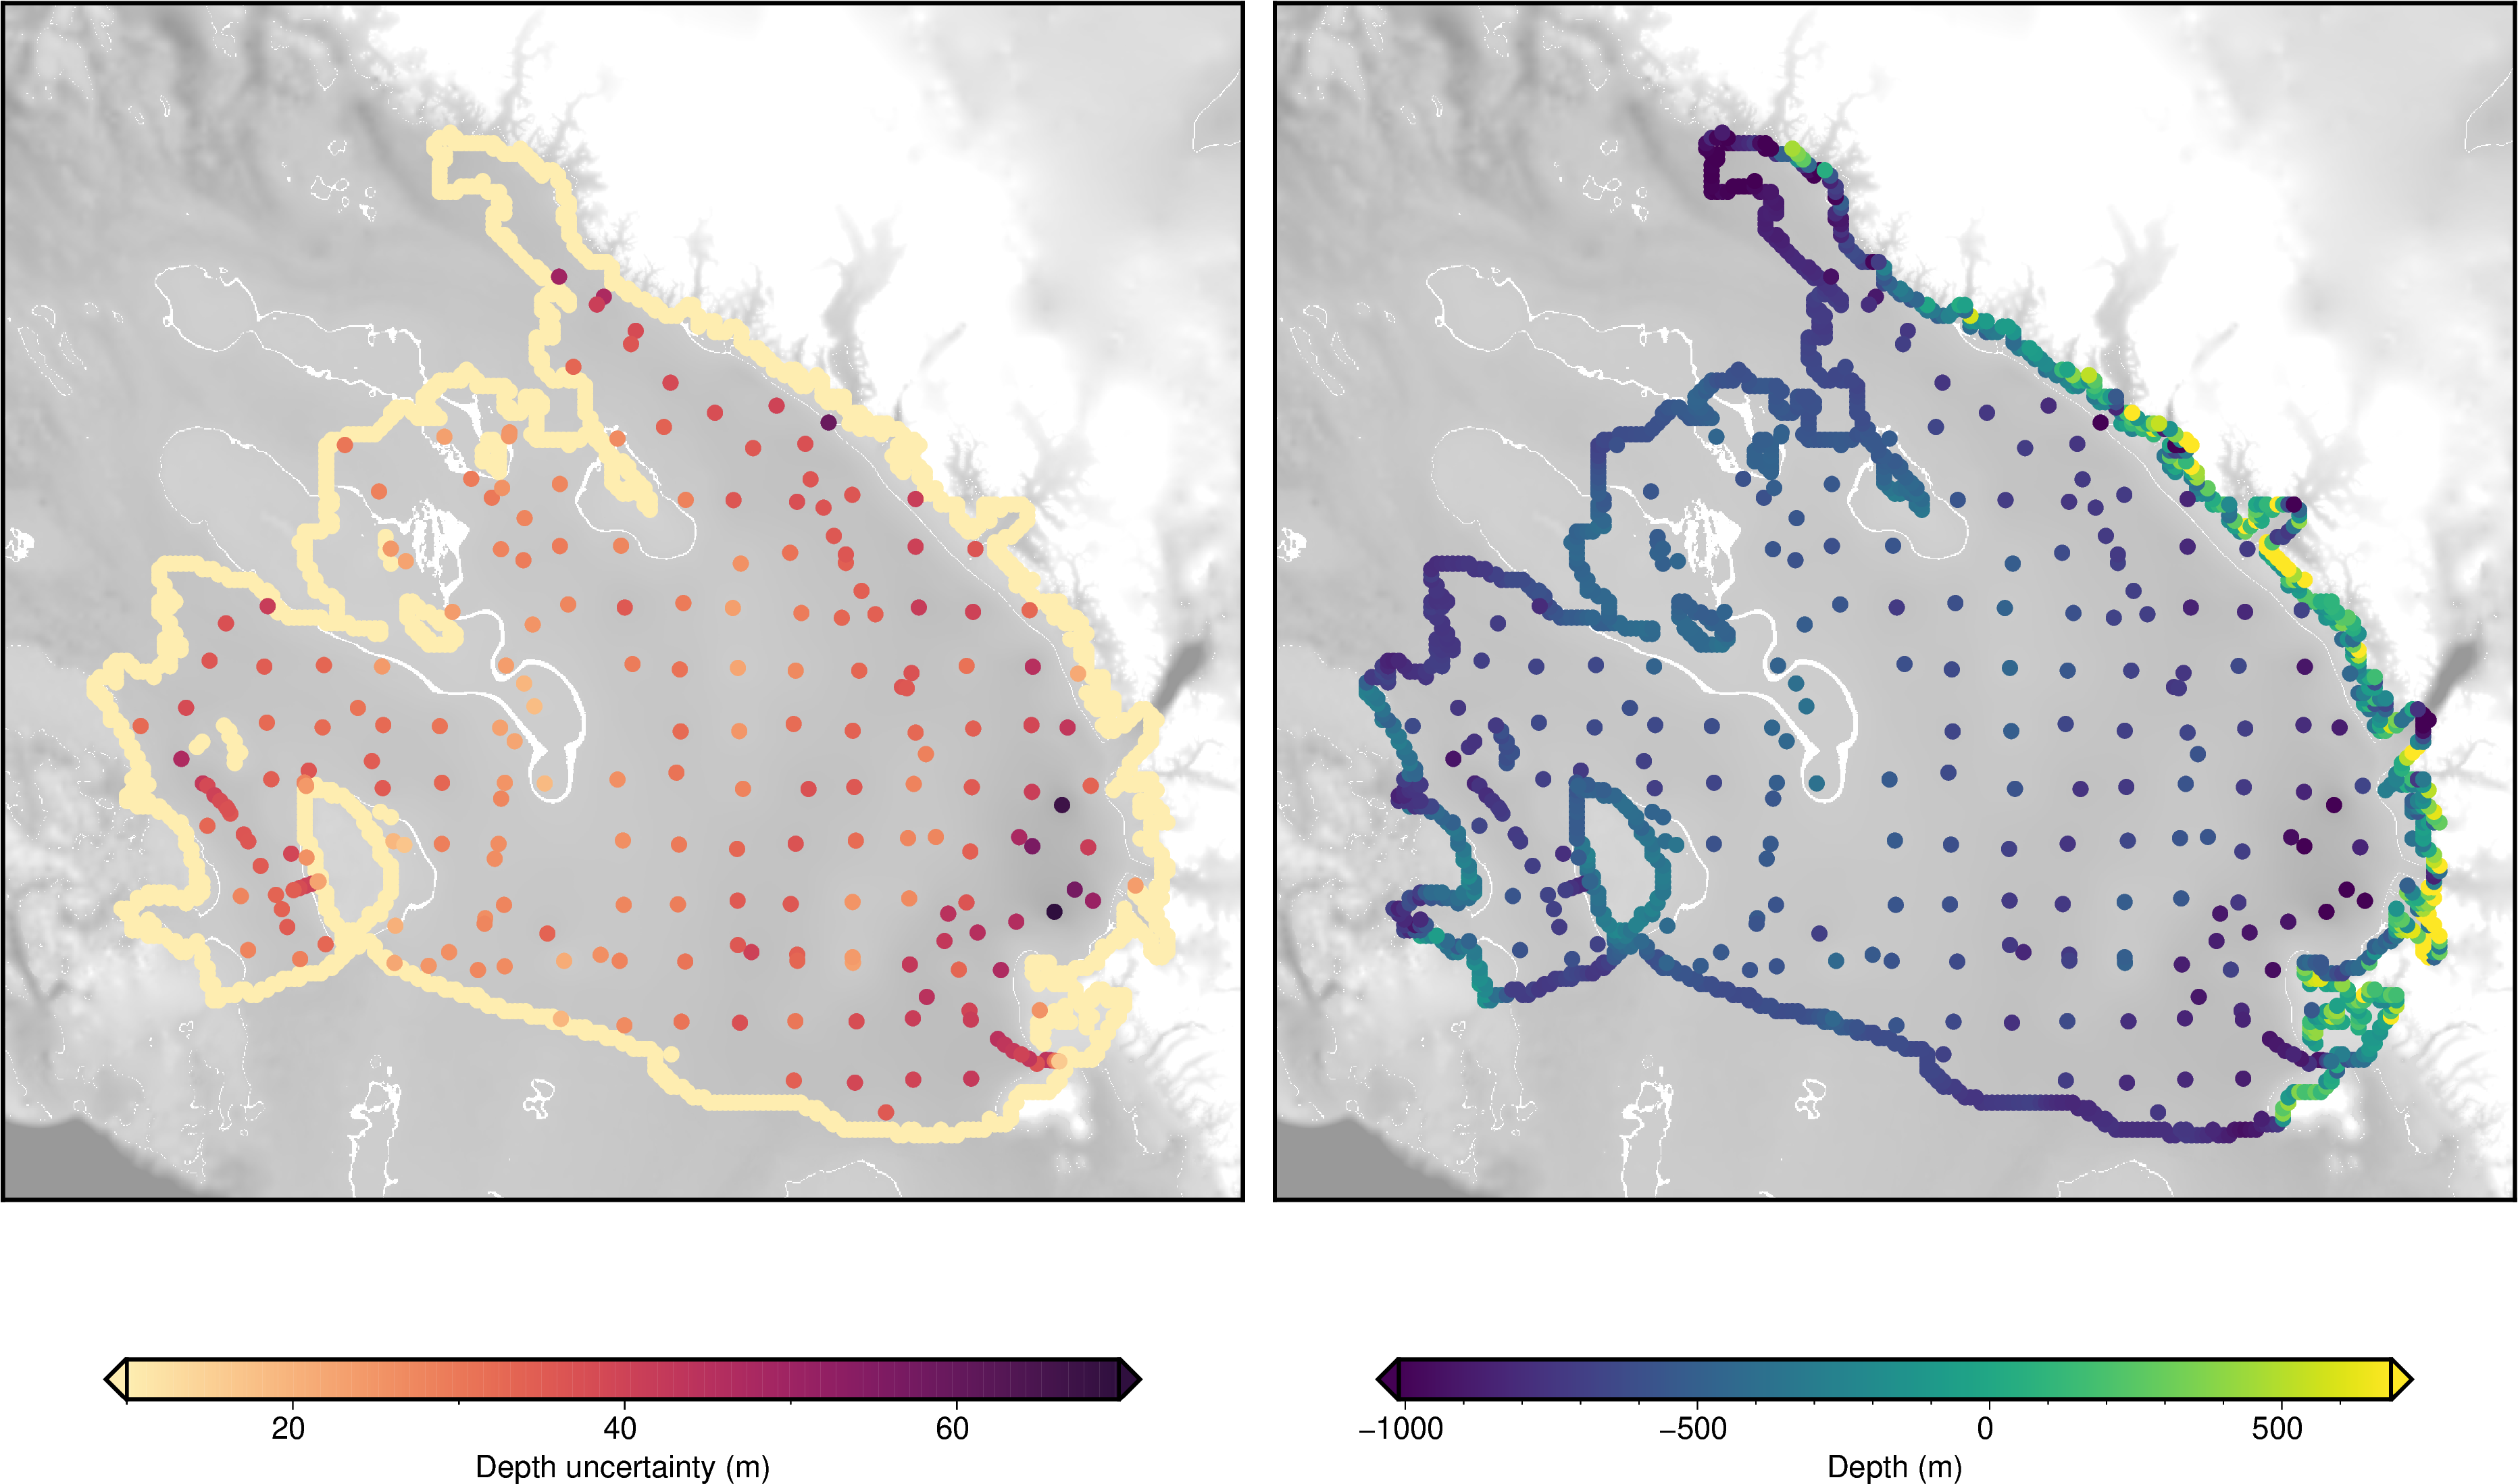

In [20]:
df = buffer_and_inside_points

fig = maps.plot_grd(
    # bedmachine_bed,
    bedmap2_bed_full,
    region=regions.ross_ice_shelf,
    cmap="gray",
    transparency=60,
    cpt_lims=[-2000, 1000],
    colorbar=False,
)
pygmt.makecpt(
    cmap="matter",
    series=polar_utils.get_min_max(df.uncert, robust=False),
    background="o",
)
fig.plot(
    x=df.easting,
    y=df.northing,
    style="c.2c",
    fill=df.uncert,
    cmap=True,
)

maps.add_colorbar(fig=fig, cbar_label="Depth uncertainty (m)", cbar_yoffset=2)

fig = maps.plot_grd(
    # bedmachine_bed,
    bedmap2_bed_full,
    region=regions.ross_ice_shelf,
    cmap="gray",
    transparency=60,
    cpt_lims=[-2000, 1000],
    colorbar=False,
    fig=fig,
    origin_shift="xshift",
)

pygmt.makecpt(
    cmap="viridis",
    series=polar_utils.get_min_max(df.upward, robust=True),
    background="o",
)
fig.plot(
    x=df.easting,
    y=df.northing,
    style="c.2c",
    fill=df.upward,
    cmap=True,
)

maps.add_colorbar(fig=fig, cbar_label="Depth (m)", cbar_yoffset=2)

fig.show()

### with verde.Spline

In [84]:
bed_from_constraints_verde_spline = utils.create_topography(
    method="splines",
    region=buffer_region,
    spacing=layer_spacing,
    constraints_df=buffer_and_inside_points,
    # weights = buffer_and_inside_points.weights,
    dampings=[None, 1e-10, 1e-8, 1e-6, 1e-4, 1e-2],
)
bed_from_constraints_verde_spline

/home/mdtanker/miniforge3/envs/RIS_gravity_inversion/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning:

Ill-conditioned matrix (rcond=4.20065e-18): result may not be accurate.

/home/mdtanker/miniforge3/envs/RIS_gravity_inversion/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning:

Ill-conditioned matrix (rcond=4.50116e-18): result may not be accurate.

/home/mdtanker/miniforge3/envs/RIS_gravity_inversion/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning:

Ill-conditioned matrix (rcond=4.17738e-18): result may not be accurate.

/home/mdtanker/miniforge3/envs/RIS_gravity_inversion/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning:

Ill-conditioned matrix (rcond=3.92098e-18): result may not be accurate.

/home/mdtanker/miniforge3/envs/RIS_gravity_inversion/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning:

Ill-conditioned matrix (rcond=4.30819e

<xarray.DataArray 'scalars' (northing: 217, easting: 217)> Size: 377kB
array([[ 2744.54836663,  2684.88346664,  2625.33683403, ...,
         2812.32183617,  2932.87705585,  3055.01268021],
       [ 2705.87249365,  2646.43134473,  2587.09029581, ...,
         2780.48891224,  2901.08140881,  3023.26889232],
       [ 2667.80410622,  2608.59618765,  2549.46954742, ...,
         2749.84576473,  2870.47095811,  2992.70648305],
       ...,
       [ 2465.450434  ,  2406.89017997,  2349.17120605, ...,
        18186.16630257, 18282.42294073, 18379.80426185],
       [ 2566.13059628,  2507.51106968,  2449.73663624, ...,
        18380.7764231 , 18477.43769748, 18575.20239364],
       [ 2668.90405839,  2610.24894667,  2552.44346337, ...,
        18575.28218215, 18672.35399985, 18770.50871167]])
Coordinates:
  * easting   (easting) float64 2kB -6.2e+05 -6.15e+05 ... 4.55e+05 4.6e+05
  * northing  (northing) float64 2kB -1.46e+06 -1.455e+06 ... -3.85e+05 -3.8e+05
Attributes:
    metadata:  Generated by SplineCV(dampings=[None, 1e-10, 1e-08, 1e-06, 0.0...
    damping:   None

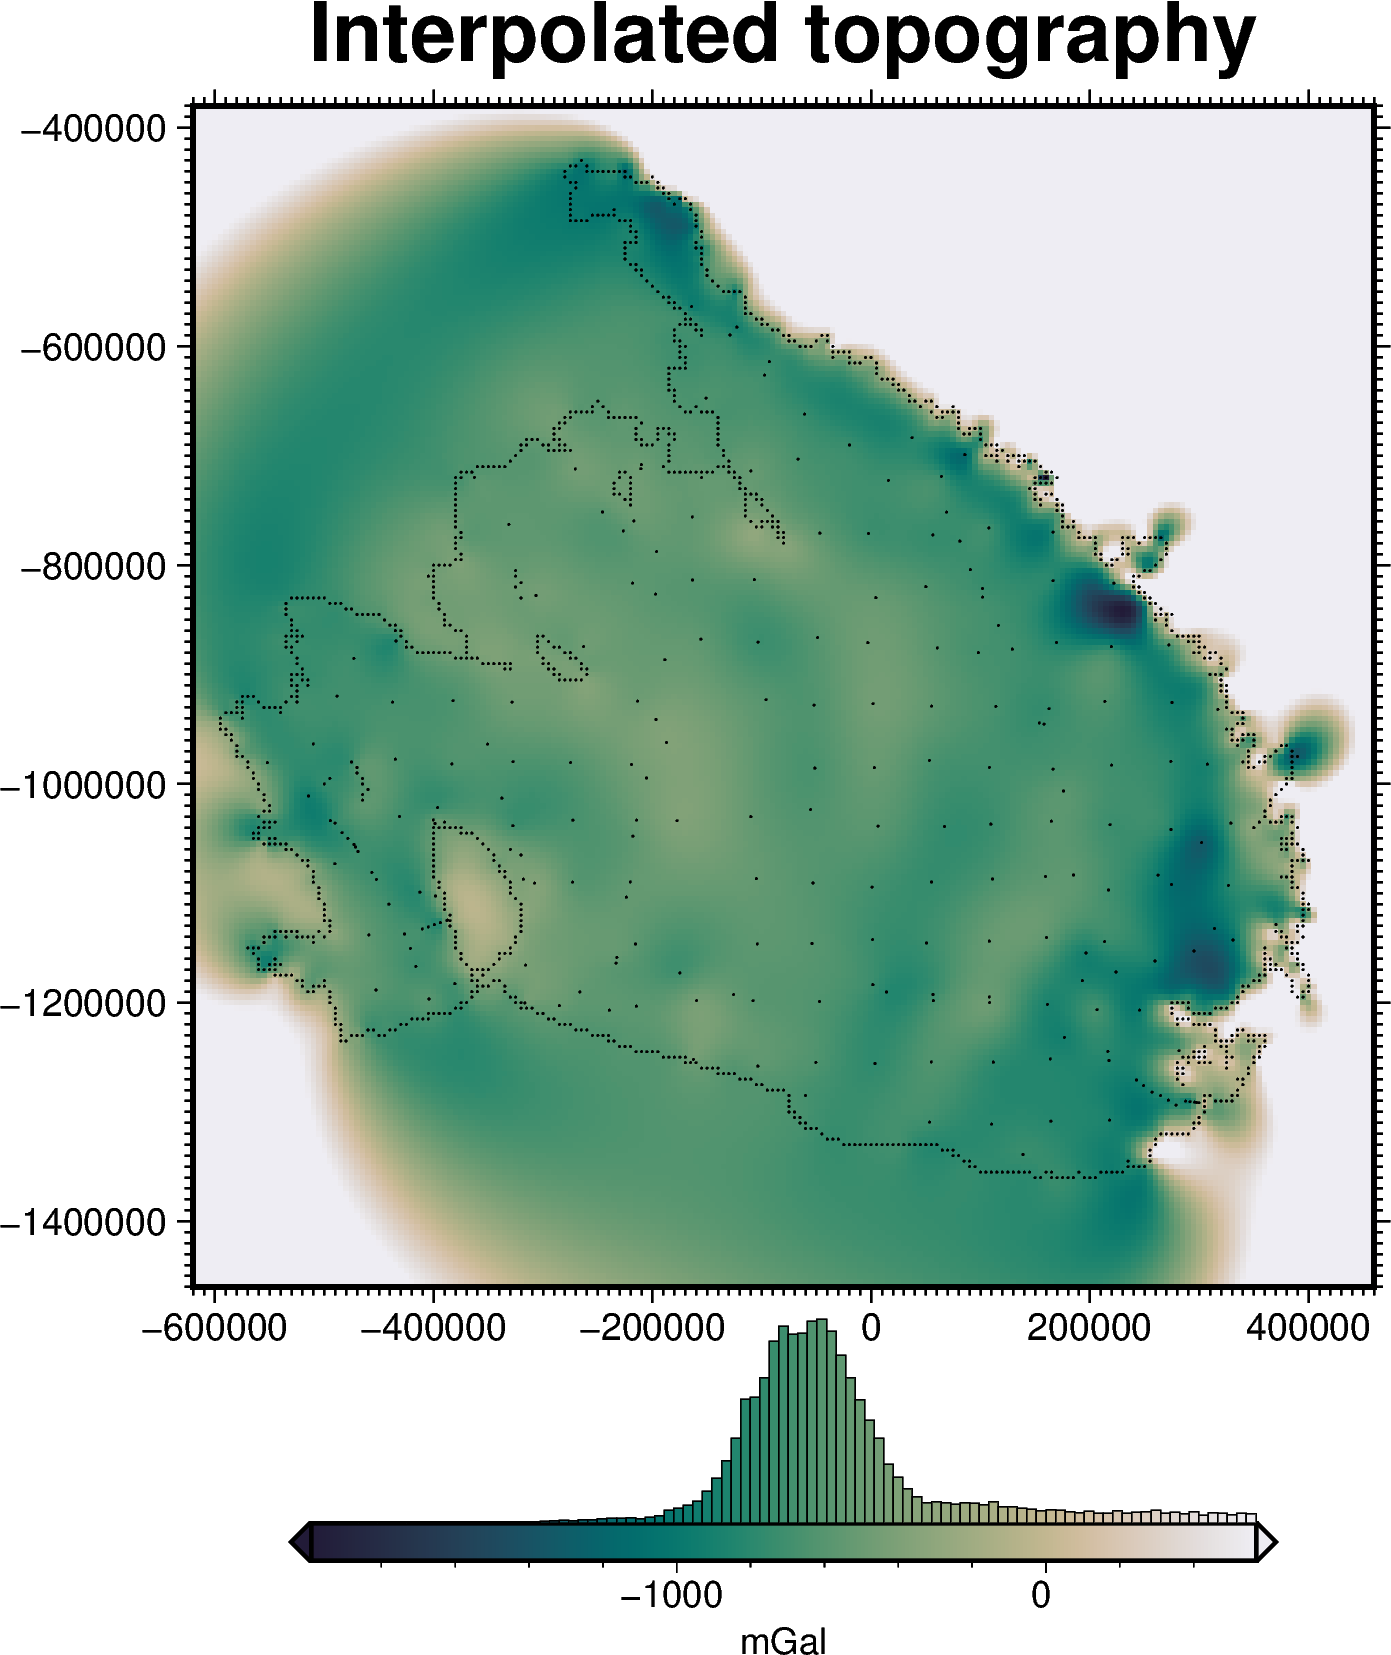

In [85]:
fig = maps.plot_grd(
    bed_from_constraints_verde_spline,
    fig_height=10,
    title="Interpolated topography",
    grounding_line=False,
    reverse_cpt=True,
    cmap="rain",
    hist=True,
    # robust=True,
    cbar_label="mGal",
    frame=["nSWe", "xaf10000", "yaf10000"],
    points=buffer_and_inside_points,
    points_style="p.02c",
    shp_mask=RIS_outline,
)
fig.show()

/home/mdtanker/miniforge3/envs/RIS_gravity_inversion/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning:

Ill-conditioned matrix (rcond=4.20065e-18): result may not be accurate.

/home/mdtanker/miniforge3/envs/RIS_gravity_inversion/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning:

Ill-conditioned matrix (rcond=4.50116e-18): result may not be accurate.

/home/mdtanker/miniforge3/envs/RIS_gravity_inversion/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning:

Ill-conditioned matrix (rcond=4.17738e-18): result may not be accurate.

/home/mdtanker/miniforge3/envs/RIS_gravity_inversion/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning:

Ill-conditioned matrix (rcond=3.92098e-18): result may not be accurate.

/home/mdtanker/miniforge3/envs/RIS_gravity_inversion/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning:

Ill-conditioned matrix (rcond=4.30819e

<xarray.DataArray 'scalars' (northing: 217, easting: 217)> Size: 377kB
array([[-3610.0300293 , -3606.81591797, -3592.93725586, ...,
         -371.77139282,   -39.91955185,   134.71720886],
       [-3618.42797852, -3621.67114258, -3581.54394531, ...,
         -263.55111694,    76.76305389,   139.97843933],
       [-3639.47143555, -3639.82568359, -3601.16479492, ...,
         -320.80804443,   -92.84288025,  -100.35599518],
       ...,
       [-1112.72241211,  -946.19927979,  -691.44830322, ...,
         -448.81411743,  -479.12960815,  -500.39199829],
       [ -984.31738281,  -545.56896973,  -345.03778076, ...,
         -409.09133911,  -439.09368896,  -465.9024353 ],
       [ -575.27209473,  -402.05020142,  -297.20916748, ...,
         -363.46936035,  -397.23065186,  -429.87069702]])
Coordinates:
  * easting   (easting) float64 2kB -6.2e+05 -6.15e+05 ... 4.55e+05 4.6e+05
  * northing  (northing) float64 2kB -1.46e+06 -1.455e+06 ... -3.85e+05 -3.8e+05
Attributes:
    metadata:  Generated by SplineCV(dampings=[None, 1e-20, 1e-10, 1e-05, 0.1...
    damping:   None

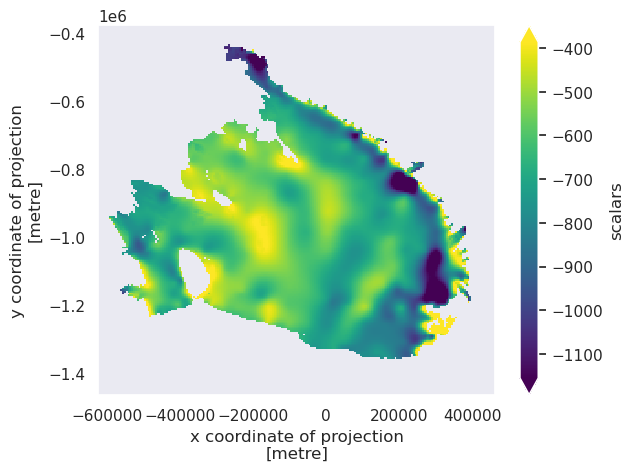

In [103]:
bed_from_constraints_verde_spline = RIS_utils.create_starting_bed(
    buffer_and_inside_points=buffer_and_inside_points,
    masked_bed=bed_outside,
    region=buffer_region,
    spacing=layer_spacing,
    icebase=bedmachine_icebase_layer_spacing,
    surface=bedmachine_surface_layer_spacing,
    method="spline",
    damping=[None, 1e-20, 1e-10, 1e-5, 1e-1],
    # weights_col_name="weights",
)

bed_from_constraints_verde_spline_clip = polar_utils.mask_from_shp(
    RIS_outline,
    xr_grid=bed_from_constraints_verde_spline,
    masked=True,
    invert=False,
)
bed_from_constraints_verde_spline_clip.plot(robust=True)
bed_from_constraints_verde_spline

### with pygmt.Surface

<xarray.DataArray 'z' (northing: 217, easting: 217)> Size: 377kB
array([[-3610.0300293 , -3606.81591797, -3592.93725586, ...,
         -371.77139282,   -39.91955185,   134.71720886],
       [-3618.42797852, -3621.67114258, -3581.54394531, ...,
         -263.55111694,    76.76305389,   139.97843933],
       [-3639.47143555, -3639.82568359, -3601.16479492, ...,
         -320.80804443,   -92.84288025,  -100.35599518],
       ...,
       [-1112.72241211,  -946.19927979,  -691.44830322, ...,
         -448.81411743,  -479.12960815,  -500.39199829],
       [ -984.31738281,  -545.56896973,  -345.03778076, ...,
         -409.09133911,  -439.09368896,  -465.9024353 ],
       [ -575.27209473,  -402.05020142,  -297.20916748, ...,
         -363.46936035,  -397.23065186,  -429.87069702]])
Coordinates:
  * northing  (northing) float64 2kB -1.46e+06 -1.455e+06 ... -3.85e+05 -3.8e+05
  * easting   (easting) float64 2kB -6.2e+05 -6.15e+05 ... 4.55e+05 4.6e+05
Attributes:
    Conventions:   CF-1.7
    title:         Data gridded with continuous surface splines in tension
    history:       gmt surface @GMTAPI@-S-I-D-V-T-N-000000 -G@GMTAPI@-S-O-G-G...
    description:   
    long_name:     z
    actual_range:  [nan nan]
    tension:       0.5

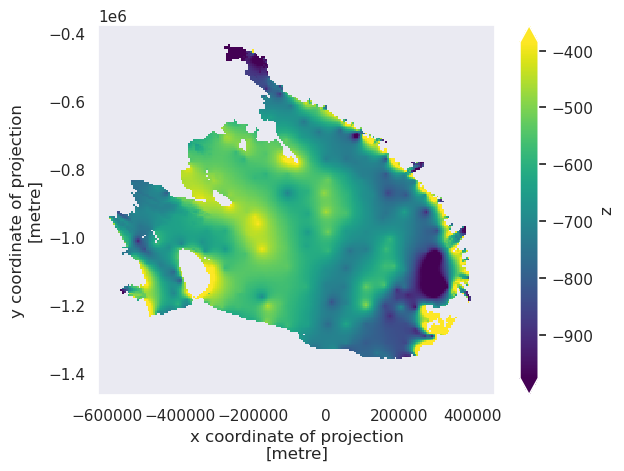

In [101]:
bed_from_constraints_gmt_surface = RIS_utils.create_starting_bed(
    buffer_and_inside_points=buffer_and_inside_points,
    masked_bed=bed_outside,
    region=buffer_region,
    spacing=layer_spacing,
    icebase=bedmachine_icebase_layer_spacing,
    surface=bedmachine_surface_layer_spacing,
    method="surface",
    tension=0.5,
)

# resample to specified layer spacing (5k)
# bed_from_constraints_gmt_surface = fetch.resample_grid(
#     bed_from_constraints_gmt_surface,
#     spacing=layer_spacing,
#     region=buffer_region,
#     registration=registration,
#     verbose="q",
# )

bed_from_constraints_gmt_surface_clip = polar_utils.mask_from_shp(
    RIS_outline,
    xr_grid=bed_from_constraints_gmt_surface,
    masked=True,
    invert=False,
)
bed_from_constraints_gmt_surface_clip.plot(robust=True)
bed_from_constraints_gmt_surface

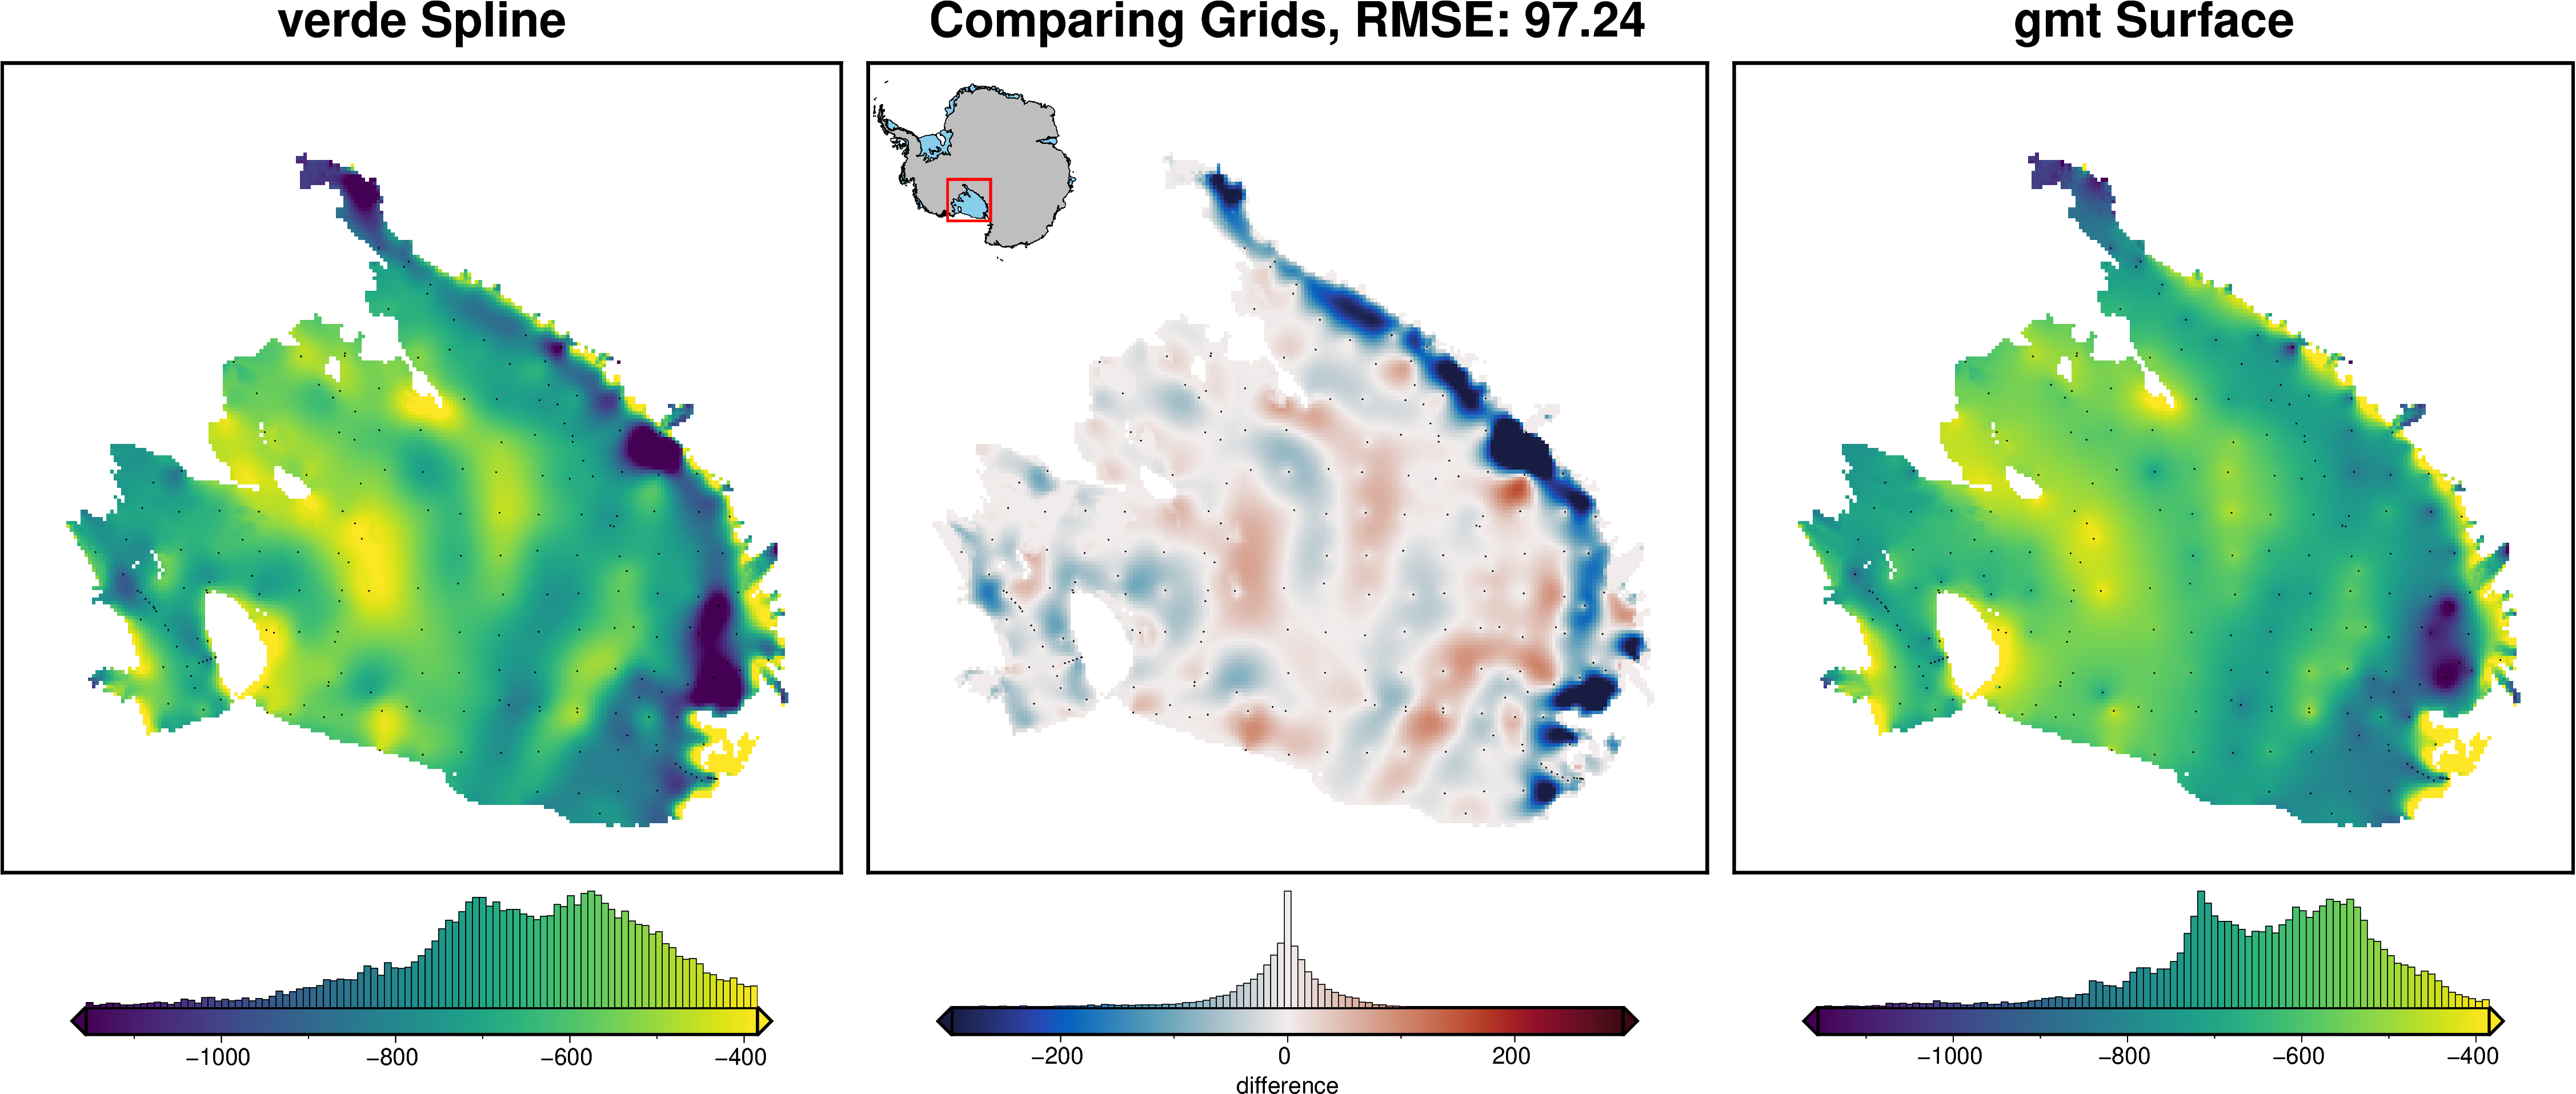

In [104]:
_ = polar_utils.grd_compare(
    bed_from_constraints_verde_spline_clip,
    bed_from_constraints_gmt_surface_clip,
    plot=True,
    points=constraints[constraints.inside],
    points_style="p.02c",
    region=regions.ross_ice_shelf,
    robust=True,
    grid1_name="verde Spline",
    grid2_name="gmt Surface",
    hist=True,
)

In [105]:
# ensure 5k versions don't cross with icebase or surface
bed_from_constraints_verde_spline = RIS_utils.ensure_no_crossing(
    bed_from_constraints_verde_spline,
    icebase=bedmachine_icebase_layer_spacing,
    surface=bedmachine_surface_layer_spacing,
)
bed_from_constraints_gmt_surface = RIS_utils.ensure_no_crossing(
    bed_from_constraints_gmt_surface,
    icebase=bedmachine_icebase_layer_spacing,
    surface=bedmachine_surface_layer_spacing,
)

In [106]:
# save to zarr
bed_from_constraints_verde_spline = bed_from_constraints_verde_spline.to_dataset(
    name="bed"
)
bed_from_constraints_verde_spline.to_zarr(
    "../../inversion_layers/bed_from_constraints_verde_spline.zarr",
    encoding={"bed": {"compressor": zarr.Blosc()}},
    mode="w",
)
bed_from_constraints_gmt_surface = bed_from_constraints_gmt_surface.to_dataset(
    name="bed"
)
bed_from_constraints_gmt_surface.to_zarr(
    "../../inversion_layers/bed_from_constraints_gmt_surface.zarr",
    encoding={"bed": {"compressor": zarr.Blosc()}},
    mode="w",
)

In [107]:
bed_from_constraints_verde_spline = xr.open_zarr(
    "../../inversion_layers/bed_from_constraints_verde_spline.zarr",
).bed
bed_from_constraints_gmt_surface = xr.open_zarr(
    "../../inversion_layers/bed_from_constraints_gmt_surface.zarr",
).bed

In [108]:
polar_utils.get_grid_info(bed_from_constraints_verde_spline)

(5000.0,
 (-620000.0, 460000.0, -1460000.0, -380000.0),
 -3684.73461914,
 4053.67944336,
 'g')

In [109]:
polar_utils.get_grid_info(bed_from_constraints_gmt_surface)

(5000.0,
 (-620000.0, 460000.0, -1460000.0, -380000.0),
 -3684.73461914,
 4053.67944336,
 'g')

# Ensemble of starting beds

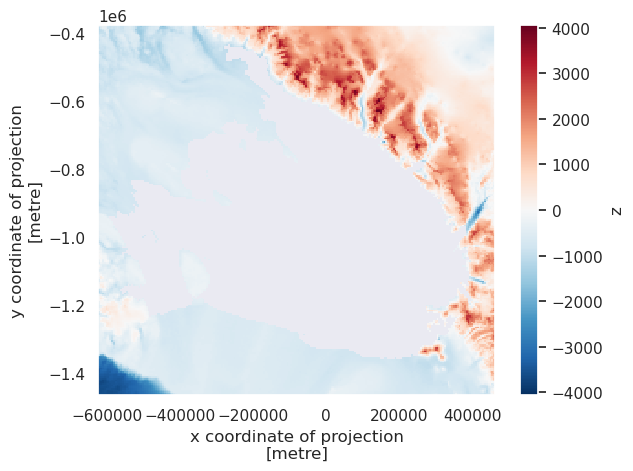

In [110]:
# get points within ice shelf border and buffered border
buffer_points, _, bed_outside = RIS_utils.get_buffer_points(
    buffer_width=layer_spacing,
    grid=bedmachine_bed_layer_spacing,
    mask=RIS_outline,
    # plot = True,
)
bed_outside.plot()

In [113]:
verde_spline_grids = []
dampings = [None, 10**-10, 10**-5]
for i, d in enumerate(dampings):
    g = RIS_utils.recreate_bed(
        inside_points=constraints[constraints.inside],
        buffer_points=buffer_points,
        outside_grid=bed_outside,
        region=buffer_region,
        layer_spacing=layer_spacing,
        method="spline",
        damping=d,
        use_weights=False,
        icebase=bedmachine_icebase_layer_spacing,
        surface=bedmachine_surface_layer_spacing,
        icebase_fullres=bedmachine_icebase_layer_spacing,
        surface_fullres=bedmachine_surface_layer_spacing,
    )
    g = g.rename(f"spline_{string.ascii_lowercase[i]}")

    verde_spline_grids.append(g)

/home/mdtanker/miniforge3/envs/RIS_gravity_inversion/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning:

Ill-conditioned matrix (rcond=4.20065e-18): result may not be accurate.

/home/mdtanker/miniforge3/envs/RIS_gravity_inversion/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning:

Ill-conditioned matrix (rcond=4.50116e-18): result may not be accurate.

/home/mdtanker/miniforge3/envs/RIS_gravity_inversion/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning:

Ill-conditioned matrix (rcond=4.17738e-18): result may not be accurate.

/home/mdtanker/miniforge3/envs/RIS_gravity_inversion/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning:

Ill-conditioned matrix (rcond=3.92098e-18): result may not be accurate.

/home/mdtanker/miniforge3/envs/RIS_gravity_inversion/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning:

Ill-conditioned matrix (rcond=4.30819e

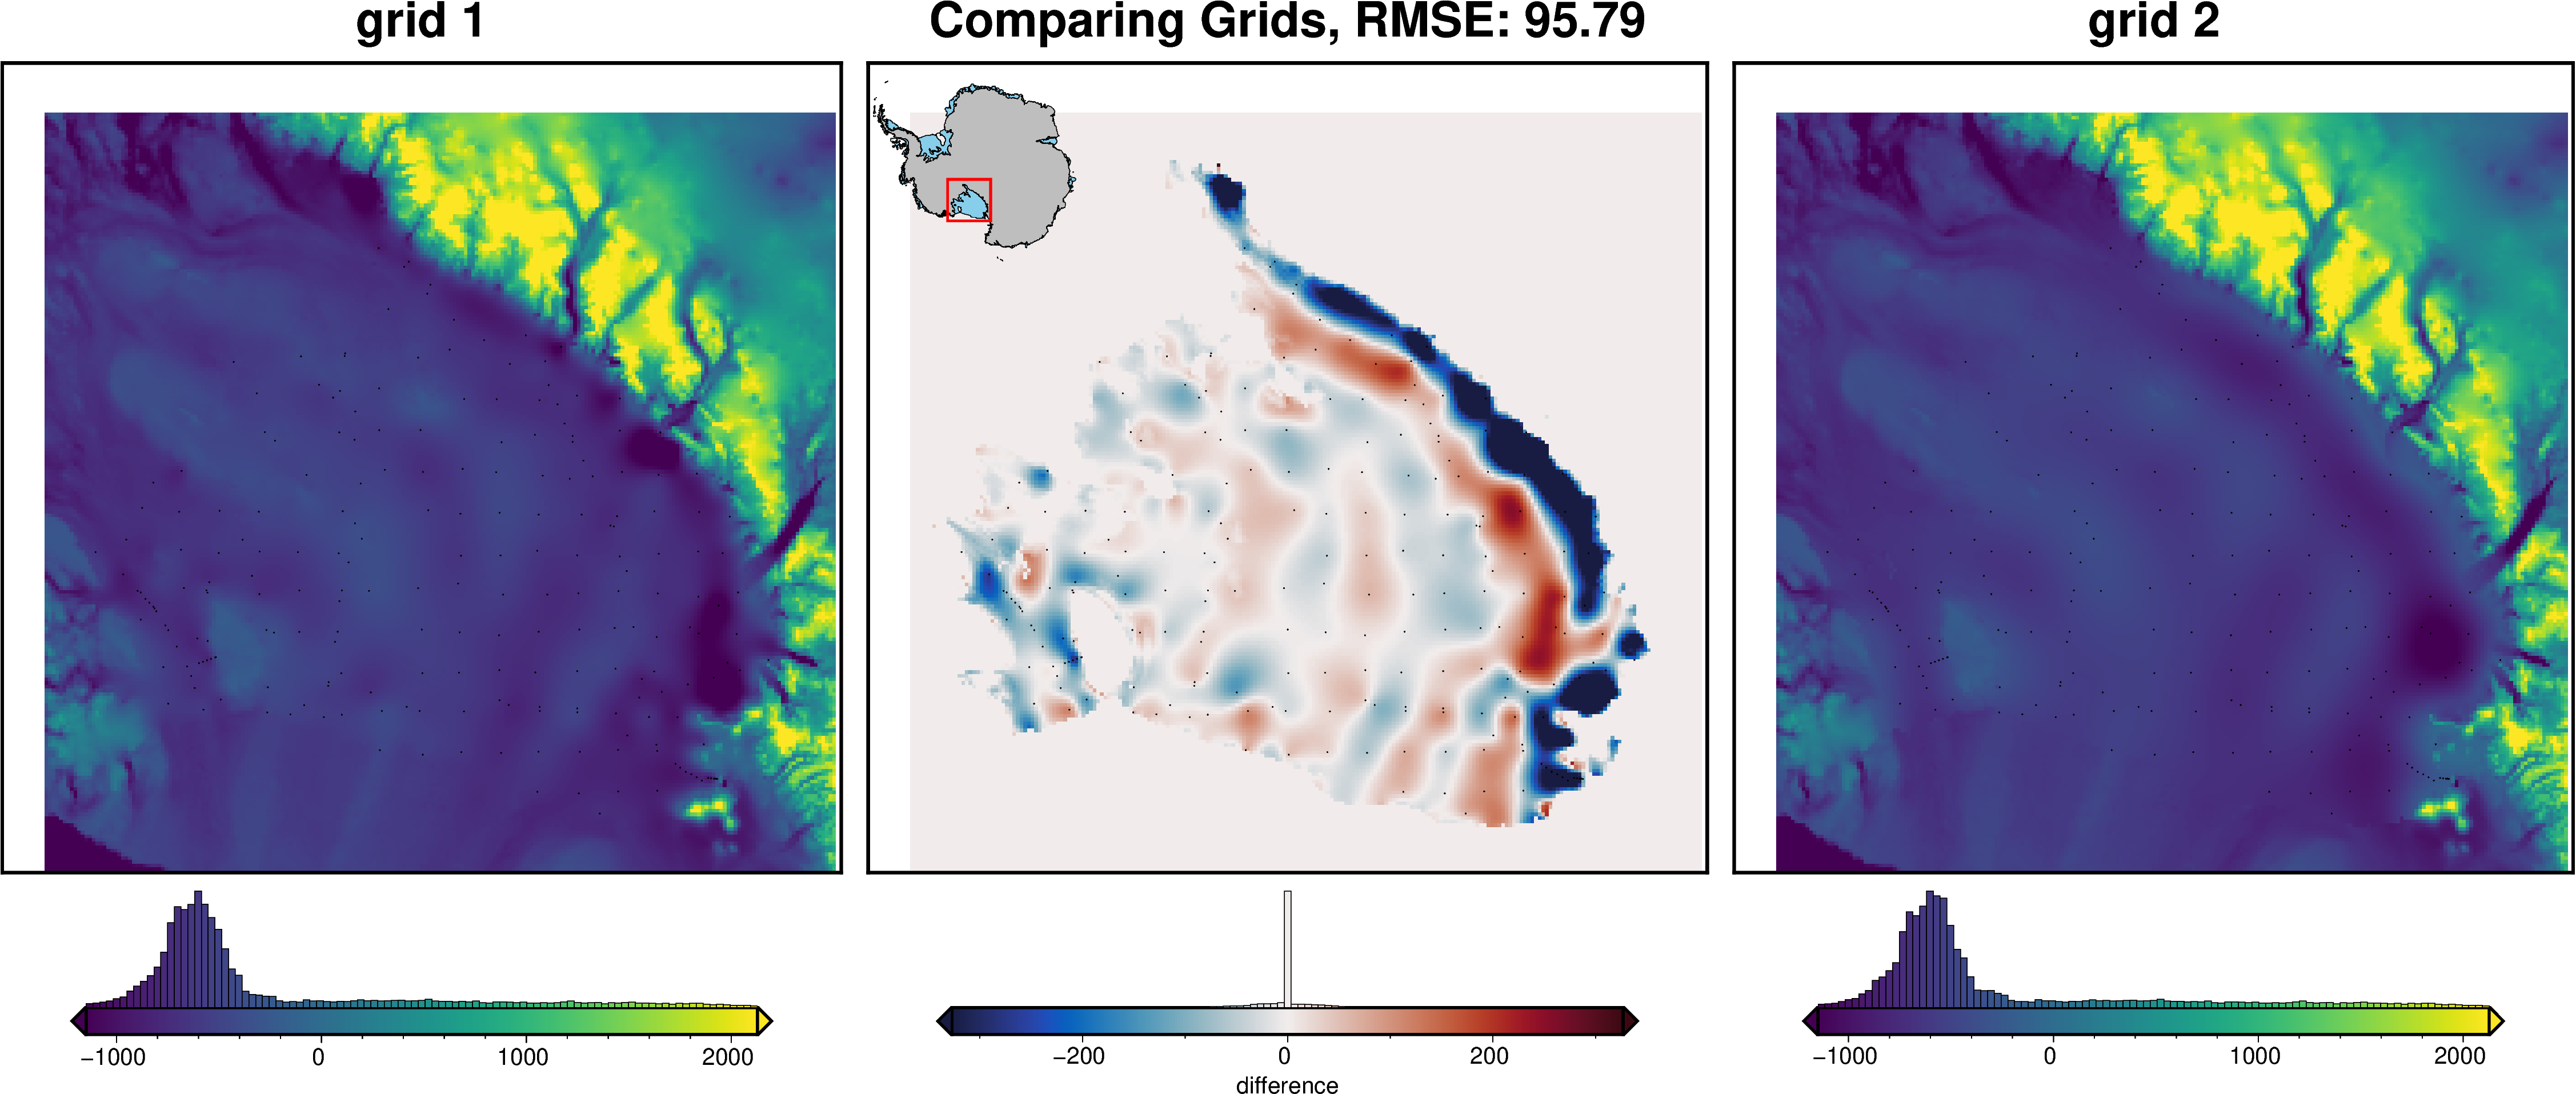

In [115]:
_ = polar_utils.grd_compare(
    verde_spline_grids[1],
    verde_spline_grids[2],
    plot=True,
    points=constraints[constraints.inside],
    points_style="p.02c",
    region=regions.ross_ice_shelf,
    robust=True,
    hist=True,
)

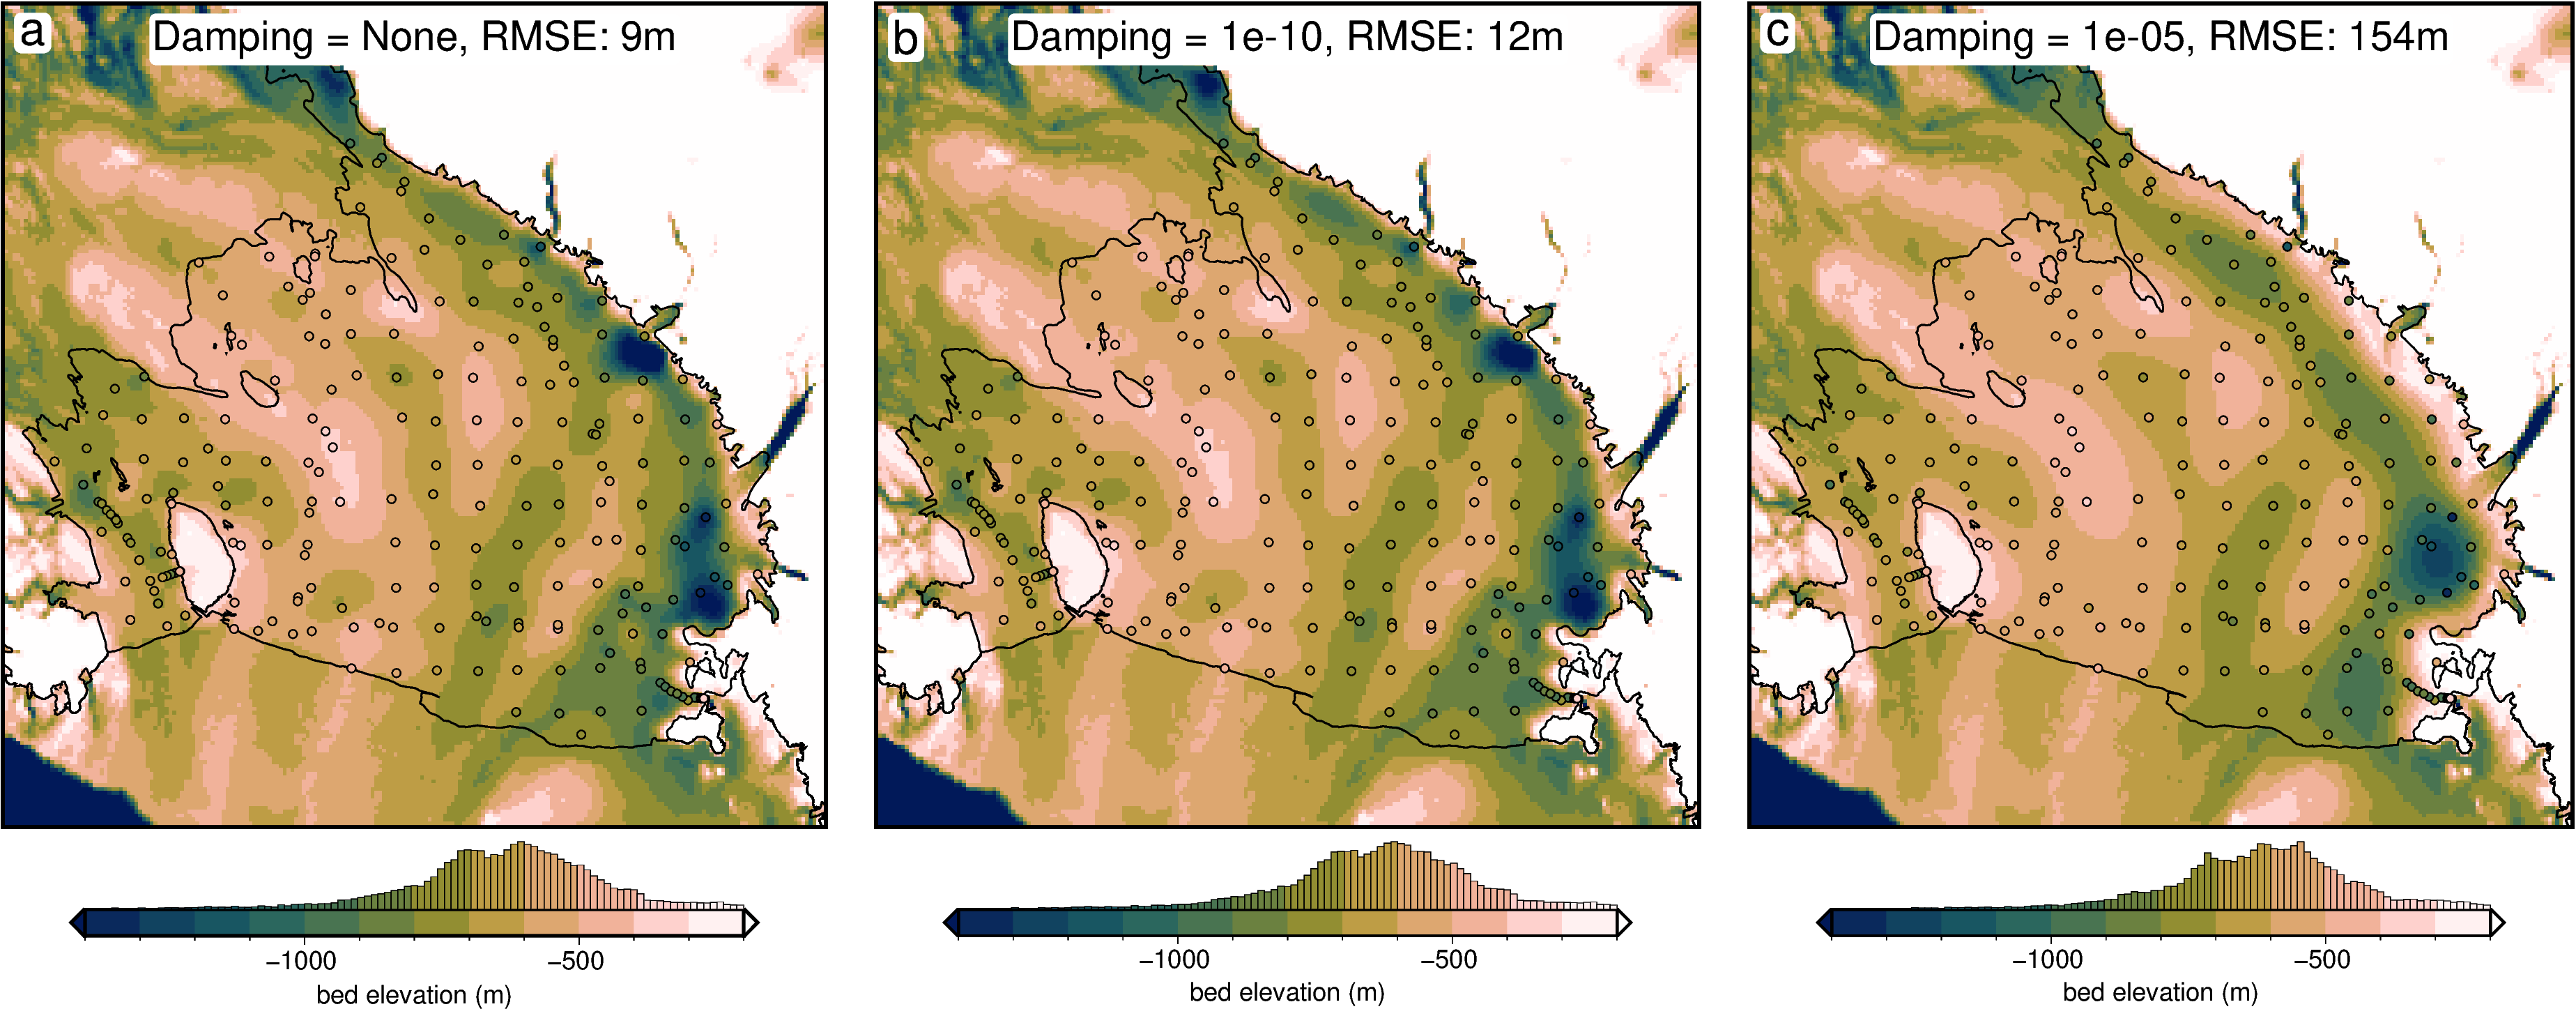

In [116]:
# set plot region
region = buffer_region

lims = [-1400, -200]
pygmt.makecpt(
    cmap="batlowW",
    series=lims + [100],
    # series="-1600/-200/100",
    output="../../plotting/tmp.cpt",
)

for i, g in enumerate(verde_spline_grids):
    # get RMSE difference at constraints
    points = profiles.sample_grids(
        constraints[constraints.inside],
        g,
        "sampled_bed",
        coord_names=["easting", "northing"],
    )
    points["dif"] = points.upward - points.sampled_bed
    rmse = utils.rmse(points.dif)

    if i == 0:
        fig = None
        origin_shift = "initialize"
        xshift_amount = 1
        yshift_amount = 1
    elif i == 3:
        fig = fig
        origin_shift = "both_shift"
        xshift_amount = -2.04
        yshift_amount = -0.95
    else:
        fig = fig
        origin_shift = "xshift"
        xshift_amount = 1.02
        yshift_amount = 1

    fig = maps.plot_grd(
        g,
        fig_height=10,
        region=region,
        coast=True,
        coast_version="measures-v2",
        cmap="../../plotting/tmp.cpt",
        # cpt_lims=lims,
        cbar_label="bed elevation (m)",
        hist=True,
        cbar_yoffset=1,
        # hist_bin_num=50,
        origin_shift=origin_shift,
        xshift_amount=xshift_amount,
        yshift_amount=yshift_amount,
        fig=fig,
    )
    # plot constraints
    fig.plot(
        x=constraints[constraints.inside].easting,
        y=constraints[constraints.inside].northing,
        fill=constraints[constraints.inside].upward,
        style="c.10c",
        pen=".4p,black",
        cmap="../../plotting/tmp.cpt",
    )
    # plot titles
    fig.text(
        position="TC",
        text=f"Damping = {dampings[i]}, RMSE: {int(rmse)}m",
        fill="white",
        font="14p,Helvetica,black",
        offset="j0/.2",
        clearance="+tO",
    )
    # plot subplot labels
    fig.text(
        position="TL",
        text=string.ascii_lowercase[i],
        fill="white",
        font="16p,Helvetica,black",
        offset="j.2/.2",
        clearance="+tO",
    )
fig.show()

In [119]:
gmt_surface_grids = []
tensions = [0, 0.2, 0.4, 0.6, 0.8, 1]

for t in tensions:
    g = RIS_utils.recreate_bed(
        inside_points=constraints[constraints.inside],
        buffer_points=buffer_points,
        outside_grid=bed_outside,
        region=buffer_region,
        layer_spacing=layer_spacing,
        method="surface",
        tension=t,
        icebase=bedmachine_icebase_layer_spacing,
        surface=bedmachine_surface_layer_spacing,
        icebase_fullres=bedmachine_icebase_layer_spacing,
        surface_fullres=bedmachine_surface_layer_spacing,
    )
    g = g.rename(f"surface_{t}")

    gmt_surface_grids.append(g)

/home/mdtanker/miniforge3/envs/RIS_gravity_inversion/lib/python3.11/site-packages/polartoolkit/maps.py:1047: UserWarning:

Since a .cpt file was passed to `cmap`, parameter `cpt_lims` is unused.

/home/mdtanker/miniforge3/envs/RIS_gravity_inversion/lib/python3.11/site-packages/polartoolkit/maps.py:1047: UserWarning:

Since a .cpt file was passed to `cmap`, parameter `cpt_lims` is unused.

/home/mdtanker/miniforge3/envs/RIS_gravity_inversion/lib/python3.11/site-packages/polartoolkit/maps.py:1047: UserWarning:

Since a .cpt file was passed to `cmap`, parameter `cpt_lims` is unused.

/home/mdtanker/miniforge3/envs/RIS_gravity_inversion/lib/python3.11/site-packages/polartoolkit/maps.py:1047: UserWarning:

Since a .cpt file was passed to `cmap`, parameter `cpt_lims` is unused.

/home/mdtanker/miniforge3/envs/RIS_gravity_inversion/lib/python3.11/site-packages/polartoolkit/maps.py:1047: UserWarning:

Since a .cpt file was passed to `cmap`, parameter `cpt_lims` is unused.

/home/mdtanker/minif

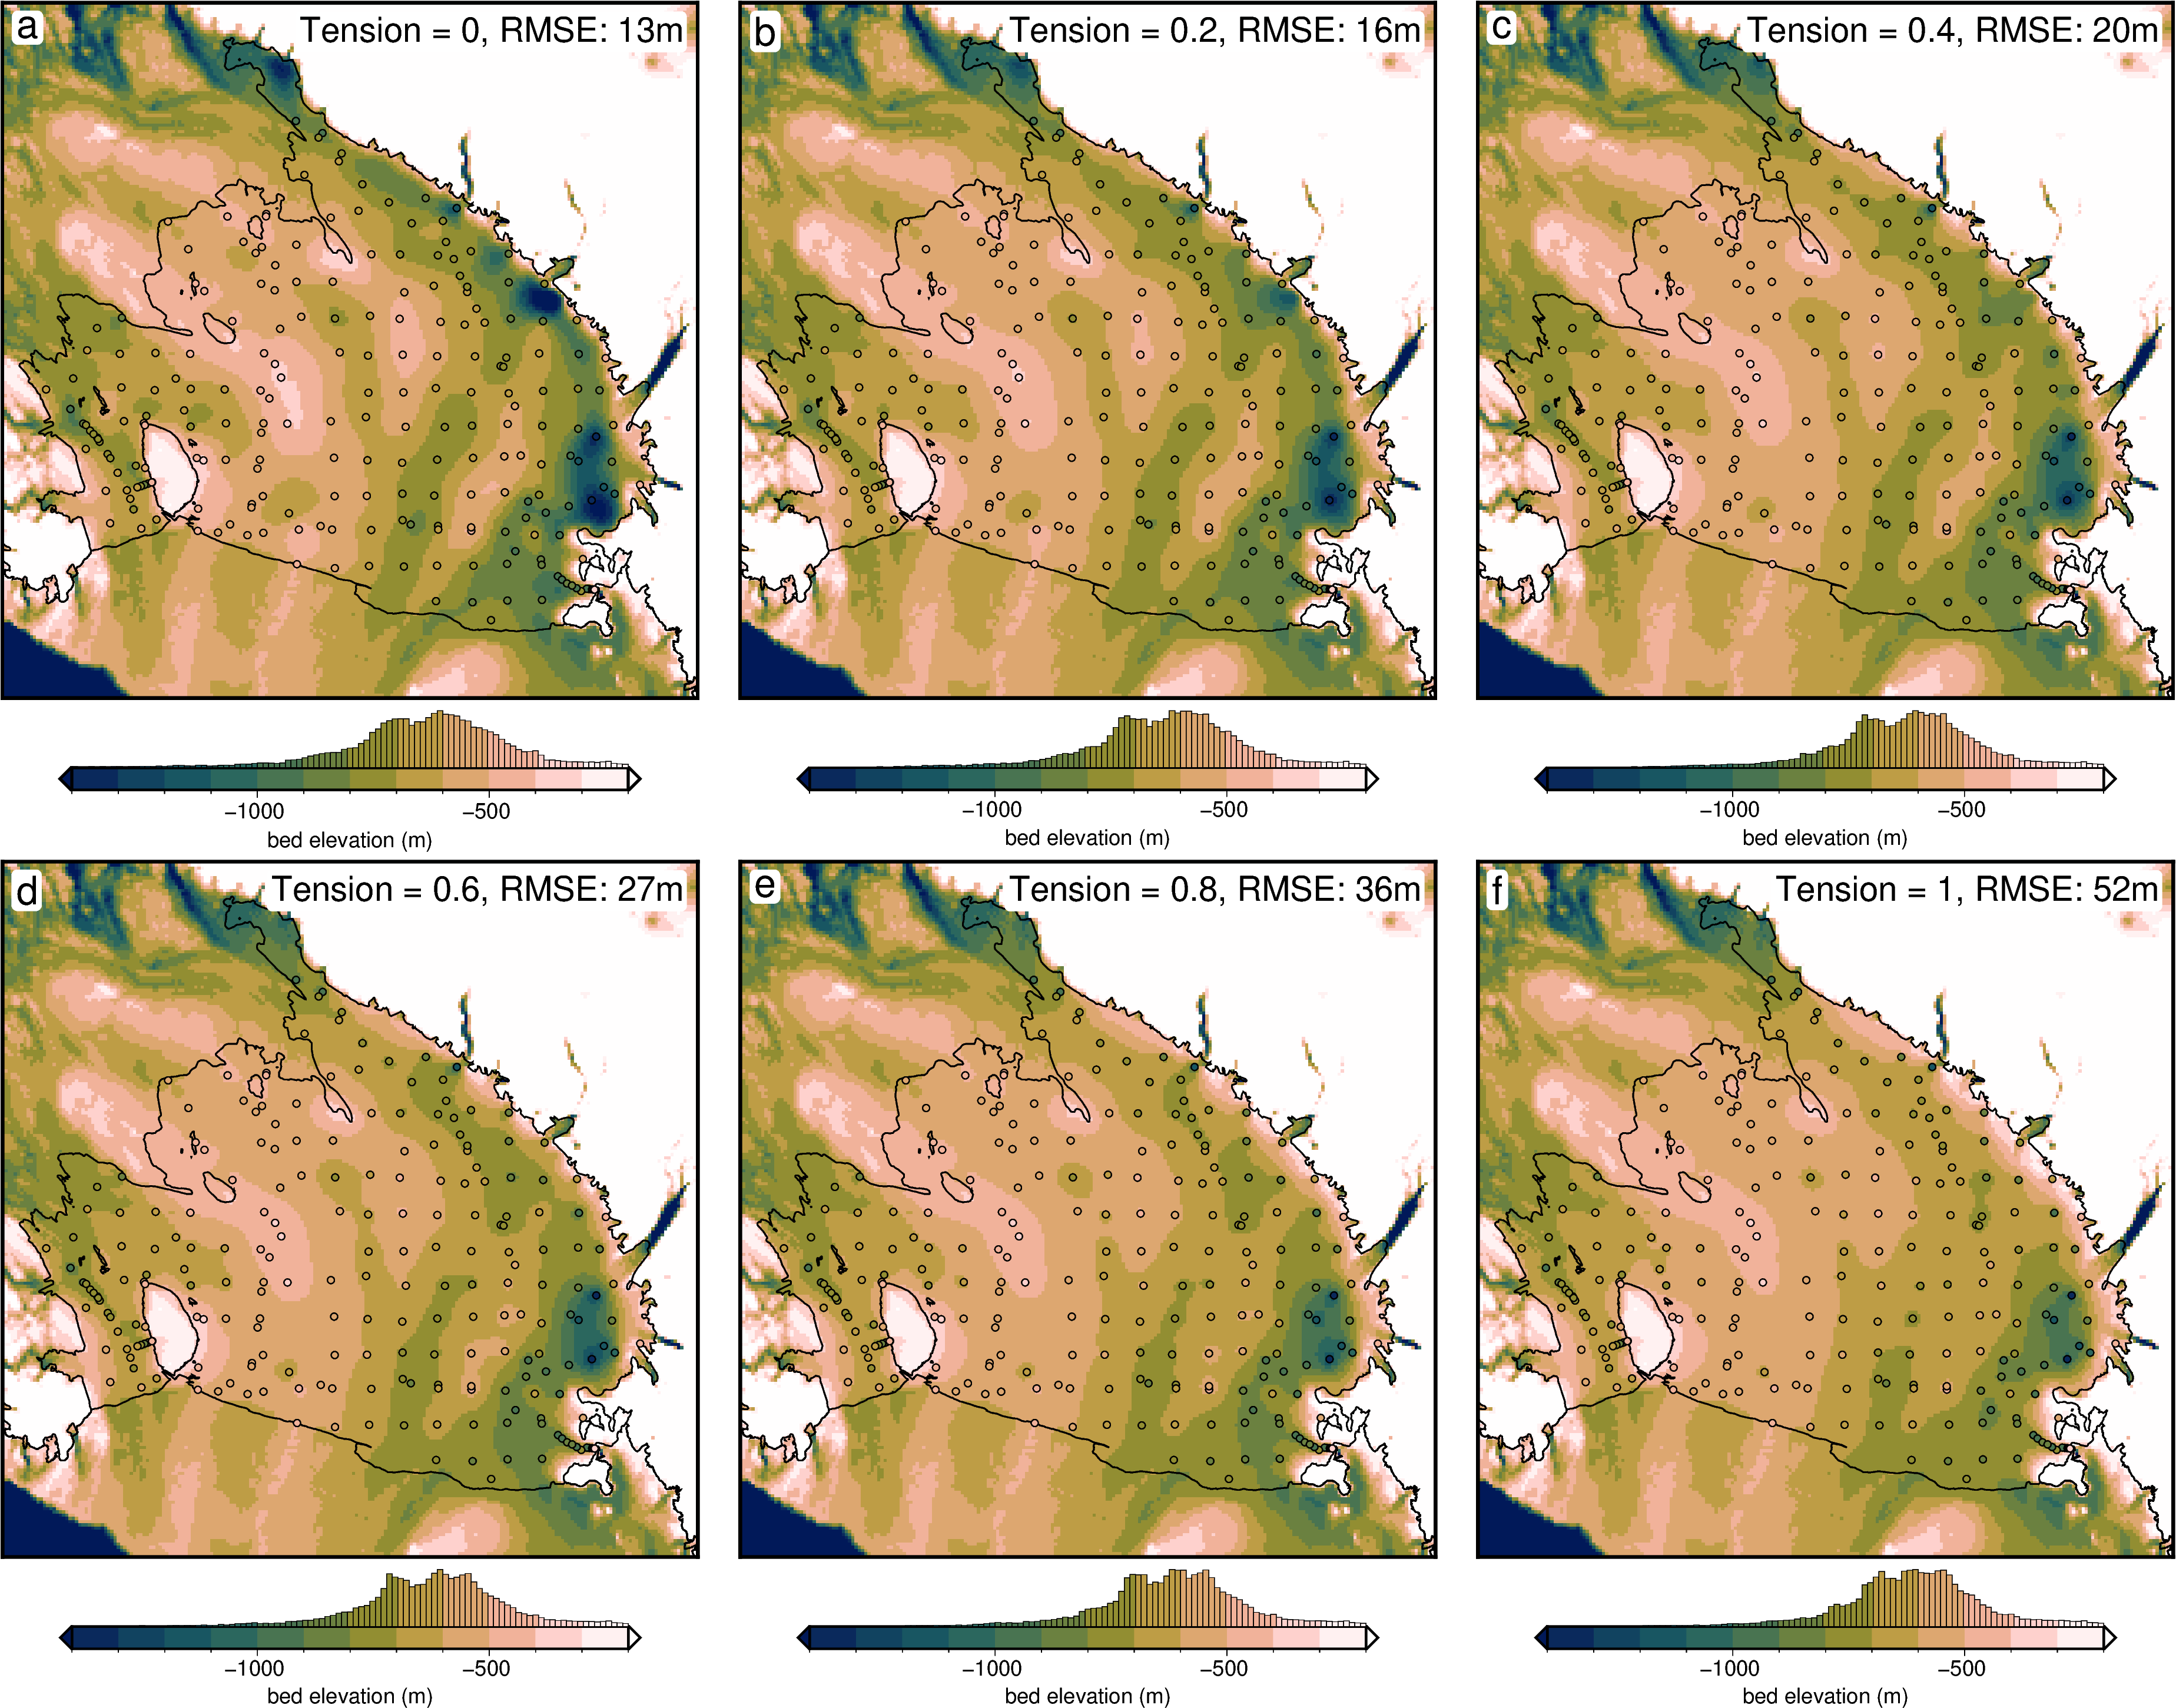

In [121]:
# set plot region
region = buffer_region

lims = [-1400, -200]
pygmt.makecpt(
    cmap="batlowW",
    series=lims + [100],
    # series="-1600/-200/100",
    output="../../plotting/tmp.cpt",
)
rmses = []
for i, g in enumerate(gmt_surface_grids):
    # get RMSE difference at constraints
    points = profiles.sample_grids(
        constraints[constraints.inside],
        g,
        "sampled_bed",
        coord_names=["easting", "northing"],
    )
    points["dif"] = points.upward - points.sampled_bed
    rmse = utils.rmse(points.dif)
    rmses.append(rmse)
    if i == 0:
        fig = None
        origin_shift = "initialize"
        xshift_amount = 1
        yshift_amount = 1
    elif i == 3:
        fig = fig
        origin_shift = "both_shift"
        xshift_amount = -2.04
        yshift_amount = -0.95
    else:
        fig = fig
        origin_shift = "xshift"
        xshift_amount = 1.02
        yshift_amount = 1

    fig = maps.plot_grd(
        g,
        fig_height=10,
        region=region,
        coast=True,
        coast_version="measures-v2",
        cmap="../../plotting/tmp.cpt",
        # cpt_lims=lims,
        cbar_label="bed elevation (m)",
        hist=True,
        cbar_yoffset=1,
        # hist_bin_num=50,
        origin_shift=origin_shift,
        xshift_amount=xshift_amount,
        yshift_amount=yshift_amount,
        fig=fig,
    )
    # plot constraints
    fig.plot(
        x=constraints[constraints.inside].easting,
        y=constraints[constraints.inside].northing,
        fill=constraints[constraints.inside].upward,
        style="c.10c",
        pen=".4p,black",
        cmap="../../plotting/tmp.cpt",
    )
    # plot titles
    fig.text(
        position="TR",
        justify="TR",
        text=f"Tension = {tensions[i]}, RMSE: {int(rmse)}m",
        fill="white",
        font="14p,Helvetica,black",
        offset="j.2/.2",
        clearance="+tO",
    )
    # plot subplot labels
    fig.text(
        position="TL",
        text=string.ascii_lowercase[i],
        fill="white",
        font="16p,Helvetica,black",
        offset="j.2/.2",
        clearance="+tO",
    )
fig.show()

In [122]:
combined = gmt_surface_grids

# save to zarr
combined = xr.merge(combined)
enc = {x: {"compressor": zarr.Blosc()} for x in combined}
combined.to_zarr(
    "../../inversion_layers/RIS_starting_bed_models.zarr",
    encoding=enc,
    mode="w",
)

In [123]:
combined = xr.open_zarr("../../inversion_layers/RIS_starting_bed_models.zarr")
combined_list = [combined[i] for i in combined]

In [128]:
stats = uncertainty.model_ensemble_stats(combined, weights=[1 / (x**2) for x in rmses])
stats

<xarray.Dataset> Size: 5MB
Dimensions:         (easting: 217, northing: 217, runs: 6)
Coordinates:
  * easting         (easting) float64 2kB -6.2e+05 -6.15e+05 ... 4.6e+05
  * northing        (northing) float64 2kB -1.46e+06 -1.455e+06 ... -3.8e+05
  * runs            (runs) <U11 264B 'surface_0' 'surface_0.2' ... 'surface_1'
Data variables:
    run_num         (runs, northing, easting) float64 2MB dask.array<chunksize=(1, 109, 217), meta=np.ndarray>
    z_mean          (northing, easting) float64 377kB dask.array<chunksize=(109, 217), meta=np.ndarray>
    z_stdev         (northing, easting) float64 377kB dask.array<chunksize=(109, 217), meta=np.ndarray>
    weighted_mean   (northing, easting) float64 377kB dask.array<chunksize=(109, 217), meta=np.ndarray>
    weighted_stdev  (northing, easting) float64 377kB dask.array<chunksize=(109, 217), meta=np.ndarray>
    z_min           (northing, easting) float64 377kB dask.array<chunksize=(109, 217), meta=np.ndarray>
    z_max           (northing, easting) float64 377kB dask.array<chunksize=(109, 217), meta=np.ndarray>

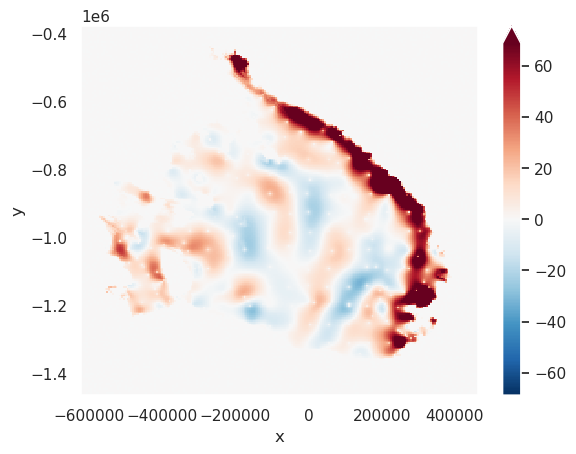

In [130]:
(stats.z_mean - stats.weighted_mean).plot(robust=True)

In [131]:
# save to zarr
enc = {x: {"compressor": zarr.Blosc()} for x in stats}
stats.to_zarr(
    "../../inversion_layers/RIS_starting_bed_stats.zarr",
    encoding=enc,
    mode="w",
)

In [132]:
stats = xr.open_zarr("../../inversion_layers/RIS_starting_bed_stats.zarr")

# Plots

In [133]:
constraints_fname = "../../data/bed_constraints.csv.gz"

constraints = pd.read_csv(
    constraints_fname,
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)
constraints

northing        easting       upward  inside     uncert   weights
0     -1.460000e+06 -620000.000000 -3610.030029   False  10.000000  0.010000
1     -1.460000e+06 -615000.000000 -3606.815918   False  10.000000  0.010000
2     -1.460000e+06 -610000.000000 -3592.937256   False  10.000000  0.010000
3     -1.460000e+06 -605000.000000 -3583.683594   False  10.000000  0.010000
4     -1.460000e+06 -600000.000000 -3592.669678   False  10.000000  0.010000
...             ...            ...          ...     ...        ...       ...
28082 -8.164639e+05 -218050.118799  -564.000000    True  28.163959  0.001261
28083 -1.087485e+06 -452466.872984  -714.000000    True  35.974822  0.000773
28084 -1.033177e+06 -214445.845201  -512.000000    True  25.265698  0.001567
28085 -8.266453e+05 -197189.312136  -583.000000    True  29.301911  0.001165
28086 -1.086833e+06  111072.987479  -652.000000    True  31.963780  0.000979

[28087 rows x 6 columns]

In [135]:
constraints = profiles.sample_grids(
    constraints,
    bed_from_constraints_verde_spline,
    "upward_verde_spline",
    coord_names=["easting", "northing"],
)
constraints = profiles.sample_grids(
    constraints,
    bed_from_constraints_gmt_surface,
    "upward_gmt_surface",
    coord_names=["easting", "northing"],
)
constraints = profiles.sample_grids(
    constraints,
    bedmap2_bed_full,
    "upward_bedmap2",
    coord_names=["easting", "northing"],
)
constraints = profiles.sample_grids(
    constraints,
    bedmachine_bed_full,
    "upward_bedmachine",
    coord_names=["easting", "northing"],
)
constraints

northing        easting       upward  inside     uncert   weights  \
0     -1.460000e+06 -620000.000000 -3610.030029   False  10.000000  0.010000   
1     -1.460000e+06 -615000.000000 -3606.815918   False  10.000000  0.010000   
2     -1.460000e+06 -610000.000000 -3592.937256   False  10.000000  0.010000   
3     -1.460000e+06 -605000.000000 -3583.683594   False  10.000000  0.010000   
4     -1.460000e+06 -600000.000000 -3592.669678   False  10.000000  0.010000   
...             ...            ...          ...     ...        ...       ...   
28082 -8.164639e+05 -218050.118799  -564.000000    True  28.163959  0.001261   
28083 -1.087485e+06 -452466.872984  -714.000000    True  35.974822  0.000773   
28084 -1.033177e+06 -214445.845201  -512.000000    True  25.265698  0.001567   
28085 -8.266453e+05 -197189.312136  -583.000000    True  29.301911  0.001165   
28086 -1.086833e+06  111072.987479  -652.000000    True  31.963780  0.000979   

       upward_verde_spline  upward_gmt_surface  upward_bedmap2  \
0             -3610.030029        -3610.030029    -3661.864990   
1             -3606.815918        -3606.815918    -3691.953125   
2             -3592.937256        -3592.937256    -3681.022217   
3             -3583.683594        -3583.683594    -3668.111572   
4             -3592.669678        -3592.669678    -3633.197510   
...                    ...                 ...             ...   
28082          -564.157364         -562.677138     -613.473231   
28083          -714.853458         -705.104890     -766.343844   
28084          -512.227997         -512.663334     -563.391749   
28085          -582.819300         -578.145611     -631.617827   
28086          -651.949624         -651.573294     -702.923834   

       upward_bedmachine  
0           -3609.998047  
1           -3606.445068  
2           -3592.634033  
3           -3583.400391  
4           -3592.614258  
...                  ...  
28082        -590.736056  
28083        -744.710992  
28084        -572.460464  
28085        -596.697515  
28086        -718.677230  

[28087 rows x 10 columns]

In [136]:
constraints["upward_diff_verde_spline"] = (
    constraints.upward - constraints.upward_verde_spline
)

constraints["upward_diff_gmt_surface"] = (
    constraints.upward - constraints.upward_gmt_surface
)

constraints["upward_diff_bedmap2"] = constraints.upward - constraints.upward_bedmap2

constraints["upward_diff_bedmachine"] = (
    constraints.upward - constraints.upward_bedmachine
)
constraints

northing        easting       upward  inside     uncert   weights  \
0     -1.460000e+06 -620000.000000 -3610.030029   False  10.000000  0.010000   
1     -1.460000e+06 -615000.000000 -3606.815918   False  10.000000  0.010000   
2     -1.460000e+06 -610000.000000 -3592.937256   False  10.000000  0.010000   
3     -1.460000e+06 -605000.000000 -3583.683594   False  10.000000  0.010000   
4     -1.460000e+06 -600000.000000 -3592.669678   False  10.000000  0.010000   
...             ...            ...          ...     ...        ...       ...   
28082 -8.164639e+05 -218050.118799  -564.000000    True  28.163959  0.001261   
28083 -1.087485e+06 -452466.872984  -714.000000    True  35.974822  0.000773   
28084 -1.033177e+06 -214445.845201  -512.000000    True  25.265698  0.001567   
28085 -8.266453e+05 -197189.312136  -583.000000    True  29.301911  0.001165   
28086 -1.086833e+06  111072.987479  -652.000000    True  31.963780  0.000979   

       upward_verde_spline  upward_gmt_surface  upward_bedmap2  \
0             -3610.030029        -3610.030029    -3661.864990   
1             -3606.815918        -3606.815918    -3691.953125   
2             -3592.937256        -3592.937256    -3681.022217   
3             -3583.683594        -3583.683594    -3668.111572   
4             -3592.669678        -3592.669678    -3633.197510   
...                    ...                 ...             ...   
28082          -564.157364         -562.677138     -613.473231   
28083          -714.853458         -705.104890     -766.343844   
28084          -512.227997         -512.663334     -563.391749   
28085          -582.819300         -578.145611     -631.617827   
28086          -651.949624         -651.573294     -702.923834   

       upward_bedmachine  upward_diff_verde_spline  upward_diff_gmt_surface  \
0           -3609.998047                  0.000000                 0.000000   
1           -3606.445068                  0.000000                 0.000000   
2           -3592.634033                  0.000000                 0.000000   
3           -3583.400391                  0.000000                 0.000000   
4           -3592.614258                  0.000000                 0.000000   
...                  ...                       ...                      ...   
28082        -590.736056                  0.157364                -1.322862   
28083        -744.710992                  0.853458                -8.895110   
28084        -572.460464                  0.227997                 0.663334   
28085        -596.697515                 -0.180700                -4.854389   
28086        -718.677230                 -0.050376                -0.426706   

       upward_diff_bedmap2  upward_diff_bedmachine  
0                51.834961               -0.031982  
1                85.137207               -0.370850  
2                88.084961               -0.303223  
3                84.427979               -0.283203  
4                40.527832               -0.055420  
...                    ...                     ...  
28082            49.473231               26.736056  
28083            52.343844               30.710992  
28084            51.391749               60.460464  
28085            48.617827               13.697515  
28086            50.923834               66.677230  

[28087 rows x 14 columns]

makecpt [WARNING]: Without inc in -T option, -Z has no effect (ignored)


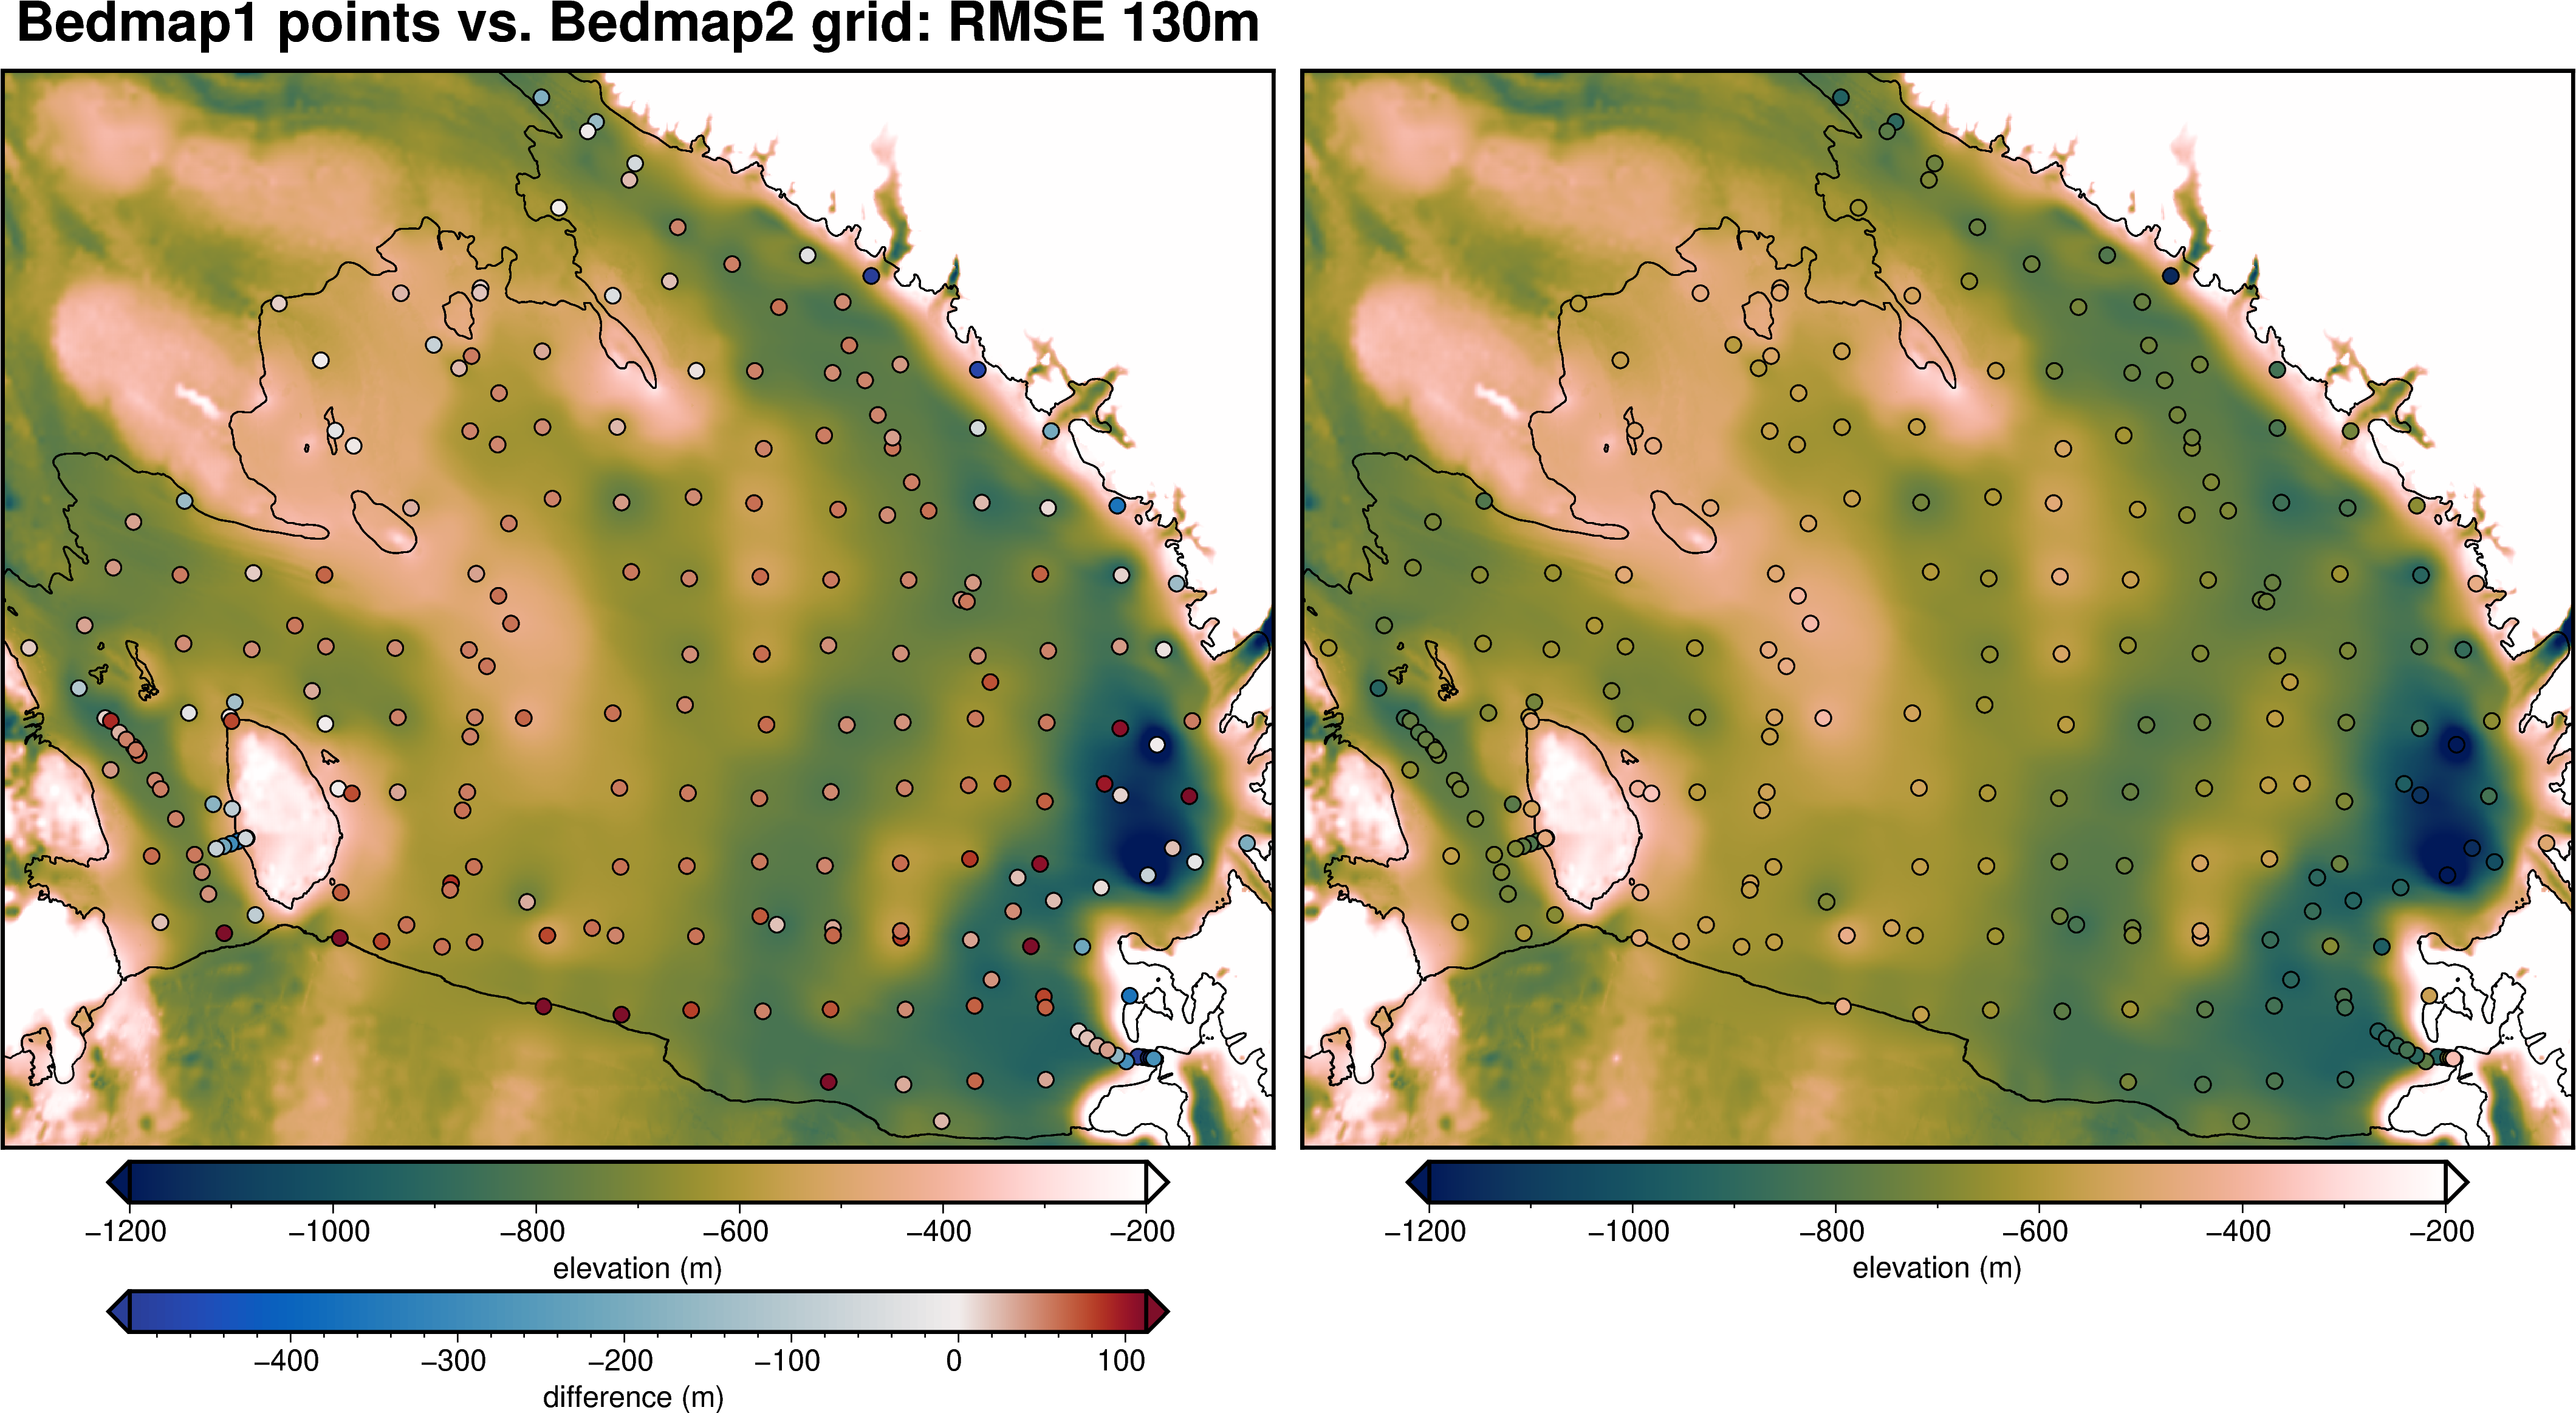

In [137]:
df = constraints[constraints.inside]
dif = df.upward_diff_bedmap2

rmse = int(utils.rmse(dif))
fig = maps.plot_grd(
    bedmap2_bed_full,
    cmap="batlowW",
    cpt_lims=[-1200, -200],
    region=vd.pad_region(vd.get_region((df.easting, df.northing)), 20e3),
    coast=True,
    coast_type="measures-v2",
    title=f"Bedmap1 points vs. Bedmap2 grid: RMSE {rmse}m",
    cbar_label="elevation (m)",
)

lims = polar_utils.get_min_max(dif, robust=True)

# make colorscale
pygmt.makecpt(
    cmap="balance+h0",
    truncate=[-0.8, 0.8],
    series=lims,
    background="o",
    continuous=True,
)

# plot data
fig.plot(
    x=df.easting,
    y=df.northing,
    fill=dif,
    style="c.22c",
    pen=".6p,black",
    cmap=True,
)

maps.add_colorbar(fig, cbar_yoffset=2, cbar_label="difference (m) ")


fig = maps.plot_grd(
    bedmap2_bed_full,
    cmap="batlowW",
    cpt_lims=[-1200, -200],
    region=vd.pad_region(vd.get_region((df.easting, df.northing)), 20e3),
    coast=True,
    coast_type="measures-v2",
    cbar_label="elevation (m)",
    fig=fig,
    origin_shift="xshift",
)

# plot data
fig.plot(
    x=df.easting,
    y=df.northing,
    fill=df.upward,
    style="c.22c",
    pen=".6p,black",
    cmap=True,
)

fig.show()

In [ ]:
df = constraints[constraints.inside]
dif = df.upward_diff_bedmachine
grid = bedmachine_bed
name = "bedmachine bed"

rmse = int(utils.RMSE(dif))
fig = maps.plot_grd(
    grid,
    cmap="batlowW",
    cpt_lims=[-1200, -200],
    region=vd.pad_region(vd.get_region((df.easting, df.northing)), 20e3),
    coast=True,
    coast_type="measures-v2",
    title=f"Bedmap1 points vs. {name} grid: RMSE {rmse}m",
    cbar_label="elevation (m)",
)

lims = utils.get_min_max(dif, robust=True)

# make colorscale
pygmt.makecpt(
    cmap="balance+h0",
    truncate=[-0.8, 0.8],
    series=lims,
    background="o",
    continuous=True,
)

# plot data
fig.plot(
    x=df.easting,
    y=df.northing,
    fill=dif,
    style="c.22c",
    pen=".6p,black",
    cmap=True,
)

maps.add_colorbar(fig, cbar_yoffset=2, cbar_label="difference (m) ")


fig = maps.plot_grd(
    grid,
    cmap="batlowW",
    cpt_lims=[-1200, -200],
    region=vd.pad_region(vd.get_region((df.easting, df.northing)), 20e3),
    coast=True,
    coast_type="measures-v2",
    cbar_label="elevation (m)",
    fig=fig,
    origin_shift="xshift",
)

# plot data
fig.plot(
    x=df.easting,
    y=df.northing,
    fill=df.upward,
    style="c.22c",
    pen=".6p,black",
    cmap=True,
)

fig.show()

In [ ]:
df = constraints[constraints.inside]
dif = df.upward_diff_gmt_surface
grid = bed_from_constraints_gmt_surface
name = "GMT surface"

rmse = int(utils.RMSE(dif))
fig = maps.plot_grd(
    grid,
    cmap="batlowW",
    cpt_lims=[-1200, -200],
    region=vd.pad_region(vd.get_region((df.easting, df.northing)), 20e3),
    coast=True,
    coast_type="measures-v2",
    title=f"Bedmap1 points vs. {name} grid: RMSE {rmse}m",
    cbar_label="elevation (m)",
)

lims = utils.get_min_max(dif, robust=True)

# make colorscale
pygmt.makecpt(
    cmap="balance+h0",
    truncate=[-0.8, 0.8],
    series=lims,
    background="o",
    continuous=True,
)

# plot data
fig.plot(
    x=df.easting,
    y=df.northing,
    fill=dif,
    style="c.22c",
    pen=".6p,black",
    cmap=True,
)

maps.add_colorbar(fig, cbar_yoffset=2, cbar_label="difference (m) ")


fig = maps.plot_grd(
    grid,
    cmap="batlowW",
    cpt_lims=[-1200, -200],
    region=vd.pad_region(vd.get_region((df.easting, df.northing)), 20e3),
    coast=True,
    coast_type="measures-v2",
    cbar_label="elevation (m)",
    fig=fig,
    origin_shift="xshift",
)

# plot data
fig.plot(
    x=df.easting,
    y=df.northing,
    fill=df.upward,
    style="c.22c",
    pen=".6p,black",
    cmap=True,
)

fig.show()

In [ ]:
df = constraints[constraints.inside]
dif = df.upward_diff_verde_spline
grid = bed_from_constraints_verde_spline
name = "verde spline"

rmse = int(utils.RMSE(dif))
fig = maps.plot_grd(
    grid,
    cmap="batlowW",
    cpt_lims=[-1200, -200],
    region=vd.pad_region(vd.get_region((df.easting, df.northing)), 20e3),
    coast=True,
    coast_type="measures-v2",
    title=f"Bedmap1 points vs. {name} grid: RMSE {rmse}m",
    cbar_label="elevation (m)",
)

lims = utils.get_min_max(dif, robust=True)

# make colorscale
pygmt.makecpt(
    cmap="balance+h0",
    truncate=[-0.8, 0.8],
    series=lims,
    background="o",
    continuous=True,
)

# plot data
fig.plot(
    x=df.easting,
    y=df.northing,
    fill=dif,
    style="c.22c",
    pen=".6p,black",
    cmap=True,
)

maps.add_colorbar(fig, cbar_yoffset=2, cbar_label="difference (m) ")


fig = maps.plot_grd(
    grid,
    cmap="batlowW",
    cpt_lims=[-1200, -200],
    region=vd.pad_region(vd.get_region((df.easting, df.northing)), 20e3),
    coast=True,
    coast_type="measures-v2",
    cbar_label="elevation (m)",
    fig=fig,
    origin_shift="xshift",
)

# plot data
fig.plot(
    x=df.easting,
    y=df.northing,
    fill=df.upward,
    style="c.22c",
    pen=".6p,black",
    cmap=True,
)

fig.show()

# Comparisons

In [ ]:
bed_from_constraints_verde_spline_clip = utils.mask_from_shp(
    "../../plotting/RIS_outline.shp",
    xr_grid=bed_from_constraints_verde_spline,
    masked=True,
    invert=False,
)

bed_from_constraints_gmt_surface_clip = utils.mask_from_shp(
    "../../plotting/RIS_outline.shp",
    xr_grid=bed_from_constraints_gmt_surface,
    masked=True,
    invert=False,
)

bedmachine_bed_clip = utils.mask_from_shp(
    "../../plotting/RIS_outline.shp",
    xr_grid=bedmachine_bed,
    masked=True,
    invert=False,
)

bedmap2_bed_clip = utils.mask_from_shp(
    "../../plotting/RIS_outline.shp",
    xr_grid=bedmap2_bed,
    masked=True,
    invert=False,
)

## compare spline and surface

In [ ]:
_ = utils.grd_compare(
    bed_from_constraints_verde_spline_clip,
    bed_from_constraints_gmt_surface_clip,
    plot=True,
    # plot_type="xarray",
    points=constraints[constraints.inside].rename(
        columns={"easting": "x", "northing": "y"}
    ),
    points_style="x0.1c",
    region=regions.ross_ice_shelf,
    robust=True,
    grid1_name="with Verde Spline",
    grid2_name="with GMT Surface",
    diff_name="starting bed",
)

## compare with bedmachine

In [ ]:
_ = utils.grd_compare(
    bedmachine_bed_clip,
    bed_from_constraints_verde_spline_clip,
    plot=True,
    # plot_type="xarray",
    points=constraints[constraints.inside].rename(
        columns={"easting": "x", "northing": "y"}
    ),
    points_style="x0.1c",
    region=regions.ross_ice_shelf,
    robust=True,
    hist=True,
    grid1_name="Bedmachine",
    grid2_name="Starting bed (Spline)",
)

In [ ]:
_ = utils.grd_compare(
    bedmachine_bed_clip,
    bed_from_constraints_gmt_surface_clip,
    plot=True,
    # plot_type="xarray",
    points=constraints[constraints.inside].rename(
        columns={"easting": "x", "northing": "y"}
    ),
    points_style="x0.1c",
    region=regions.ross_ice_shelf,
    robust=True,
    hist=True,
    grid1_name="Bedmachine",
    grid2_name="Starting bed (Surface)",
)

## compare with bedmap2

In [ ]:
_ = utils.grd_compare(
    bedmap2_bed_clip,
    bed_from_constraints_verde_spline_clip,
    plot=True,
    # plot_type="xarray",
    points=constraints[constraints.inside].rename(
        columns={"easting": "x", "northing": "y"}
    ),
    points_style="x0.1c",
    region=regions.ross_ice_shelf,
    robust=True,
    hist=True,
    grid1_name="Bedmap2",
    grid2_name="Starting bed (Spline)",
)

In [ ]:
_ = utils.grd_compare(
    bedmap2_bed_clip,
    bed_from_constraints_gmt_surface_clip,
    plot=True,
    # plot_type="xarray",
    points=constraints[constraints.inside].rename(
        columns={"easting": "x", "northing": "y"}
    ),
    points_style="x0.1c",
    region=regions.ross_ice_shelf,
    robust=True,
    hist=True,
    grid1_name="Bedmap2",
    grid2_name="Starting bed (Surface)",
)

## Plot ocean draft

In [ ]:
starting_bed_ocean_draft = bedmachine_icebase - bed_from_constraints
fig = maps.plot_grd(
    starting_bed_ocean_draft,
    region=regions.ross_ice_shelf,
    cmap="rain",
    # reverse_cpt=True,
    grd2cpt=True,
    cpt_lims=[0, 100],
    hist=True,
)
fig.plot(
    x=constraints[constraints.inside].easting,
    y=constraints[constraints.inside].northing,
    style="c.08c",
    fill="black",
)

bedmap2_ocean_draft = bedmap2_icebase - bedmap2_bed
fig = maps.plot_grd(
    bedmap2_ocean_draft,
    region=regions.ross_ice_shelf,
    cmap="rain",
    # reverse_cpt=True,
    grd2cpt=True,
    cpt_lims=[0, 100],
    hist=True,
    fig=fig,
    origin_shift="xshift",
)
fig.plot(
    x=constraints[constraints.inside].easting,
    y=constraints[constraints.inside].northing,
    style="c.08c",
    fill="black",
)


bedmachine_ocean_draft = bedmachine_icebase - bedmachine_bed
fig = maps.plot_grd(
    bedmachine_ocean_draft,
    region=regions.ross_ice_shelf,
    cmap="rain",
    # reverse_cpt=True,
    grd2cpt=True,
    cpt_lims=[0, 100],
    hist=True,
    fig=fig,
    origin_shift="xshift",
)
fig.plot(
    x=constraints[constraints.inside].easting,
    y=constraints[constraints.inside].northing,
    style="c.08c",
    fill="black",
)
fig.show()

In [ ]:
up_deriv = np.abs(
    inv_utils.filter_grid(bed_from_constraints.load(), filt_type="up_deriv")
)

pygmt.grd2cpt(
    grid=bed_from_constraints,
    cmap="rain",
    reverse=True,
    limit="-1500/0",
    nlevels=16,  # background=True,
    output="../../plotting/RIS_bathy.cpt",
)
fig = maps.plot_grd(
    bed_from_constraints,
    fig_height=10,
    coast=True,
    # coast_version="measures-v2",
    region=regions.ross_ice_shelf,
    cmap="../../plotting/RIS_bathy.cpt",  # "rain",
    # reverse_cpt=True,
    # grd2cpt=True,
    cpt_lims=[-1500, 0],
    cbar_label="Starting bed (m)",
    hist=True,
    cbar_yoffset=1.5,
)
fig.plot(
    x=constraints[constraints.inside].easting,
    y=constraints[constraints.inside].northing,
    style="c.06c",
    fill="white",
    pen=".5p,black",
)
info = utils.set_proj(
    regions.ross_ice_shelf,
    fig_height=10,
)
maps.add_scalebar(fig, regions.ross_ice_shelf, info[1], position="n.2/-.05")

fig = maps.plot_grd(
    up_deriv,
    coast=True,
    # coast_version="measures-v2",
    region=regions.ross_ice_shelf,
    cmap="matter",
    grd2cpt=True,
    hist=True,
    cbar_yoffset=1.5,
    cbar_label="Upward derivative (absolute value)",
    robust=True,
    cpt_lims=[0, 0.1],
    fig=fig,
    origin_shift="xshift",
)
fig.plot(
    x=constraints[constraints.inside].easting,
    y=constraints[constraints.inside].northing,
    style="c.06c",
    fill="white",
    pen=".5p,black",
)
fig.show()

# Method 2: Grid point data, RIGGS inside RIS, bedmachine outside

In [ ]:
fig = maps.plot_grd(
    bedmachine_RIGGS_filled,
    cmap="rain",
    reverse_cpt=True,
    grd2cpt=True,
    hist=True,
    cbar_yoffset=4,
)
fig.show()

### grid with verde.Spline()

In [ ]:
import harmonica as hm

eqs = hm.EquivalentSourcesGB()
eqs.estimate_required_memory(
    (inner_constraints.x, inner_constraints.y, inner_constraints.y)
)

In [ ]:
import psutil

mem = psutil.virtual_memory()
mem

In [ ]:
mem[4]

### block reduce the data

In [ ]:
reduced_constraints = utils.block_reduce(
    inner_constraints,
    np.median,
    spacing=5e3,
    input_coord_names=["x", "y"],
)
reduced_constraints

In [ ]:
spline = vd.SplineCV(
    dampings=np.logspace(-6, 3, num=10, dtype=np.float32),
    # delayed=False
)

In [ ]:
# spline = vd.Spline(
#     damping=.1,
#     # delayed=False,
# )

In [ ]:
spline.fit(
    (reduced_constraints.x, reduced_constraints.y),
    reduced_constraints.z_ellipsoidal,
)

In [ ]:
bedmachine_RIGGS_filled_vd = spline.grid(region=region, spacing=spacing).scalars

In [ ]:
fig = maps.plot_grd(
    bedmachine_RIGGS_filled_vd,
    cmap="rain",
    reverse_cpt=True,
    grd2cpt=True,
    hist=True,
    cbar_yoffset=4,
    points=reduced_constraints,
    points_style="c0.05c",
)
fig.show()

In [ ]:
difference = bedmachine_RIGGS_filled - bedmachine_RIGGS_filled_vd

fig = maps.plot_grd(
    difference,
    cmap="balance+h0",
    # grd2cpt=True,
    cbar_label="PyGMT Surface vs. Verde Spline",
    cpt_lims=[-200, 200],
    region=regions.ross_ice_shelf,
    hist=True,
    cbar_yoffset=3,
    hist_ymax=20e3,
)

fig.show()

### Compare to the Bedmachine

In [ ]:
difference = bedmachine_bed - bedmachine_RIGGS_filled

fig = maps.plot_grd(
    difference,
    cmap="balance+h0",
    # grd2cpt=True,
    cbar_label="Bedmachine vs RIGGS-filled (m)",
    cpt_lims=[-200, 200],
    region=regions.ross_ice_shelf,
    hist=True,
    cbar_yoffset=3,
    hist_ymax=20e3,
)

fig.show()

Compare to Bedmap2

In [ ]:
difference = bedmap2_bed - bedmachine_RIGGS_filled

fig = maps.plot_grd(
    difference,
    cmap="balance+h0",
    # grd2cpt=True,
    cbar_label="Bedmap2 vs RIGGS-filled (m)",
    cpt_lims=[-200, 200],
    region=regions.ross_ice_shelf,
    hist=True,
    cbar_yoffset=3,
)

fig.show()

## Save to a .zarr file

In [ ]:
bedmachine_RIGGS_filled = bedmachine_RIGGS_filled.to_dataset(name="bed")

bedmachine_RIGGS_filled.to_zarr(
    "../../inversion_layers/bedmachine_RIGGS_filled.zarr",
    encoding={"bed": {"compressor": zarr.Blosc()}},
    mode="w",
)

### Load .zarr file

In [ ]:
bedmachine_RIGGS_filled = xr.open_zarr(
    "../../inversion_layers/bedmachine_RIGGS_filled.zarr"
)["bed"]
maps.plot_grd(
    bedmachine_RIGGS_filled,
    region=regions.ross_ice_shelf,
    cmap="rain",
    reverse_cpt=True,
    grd2cpt=True,
)

## Replace grid cells at constraints and interpolate

### Mask grid within 2km of constraint points

In [ ]:
bed_constraints = pd.read_csv(
    "../../ross_ice_shelf_bed_data.csv.gz",
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)
bed_constraints.describe()

In [ ]:
spacing, region, *_ = utils.get_grid_info(bedmap_bedmachine_merge)

coords = vd.grid_coordinates(region, spacing=spacing)
grid = vd.make_xarray_grid(coords, data=np.ones_like(coords[0]), data_names="z")

mask = vd.distance_mask(
    (bed_constraints.x, bed_constraints.y),
    maxdist=2e3,
    grid=grid,
)
mask = mask.rename({"northing": "y", "easting": "x"})
mask.z.plot()

### Grid the RIGGS points

In [ ]:
# Tension factor; 0-1,
# 0 gives minimum curvature,
# 1 gives harmonic surface (max min only at constraints)
# 0.35 recommended for topography
RIGGS = pygmt.surface(
    data=bed_constraints[["x", "y", "z_ellipsoidal"]],
    region=region,
    spacing=spacing,
    T=0.35,  # tension factor
)
RIGGS.plot()

### Merge masked grid with RIGGS grid

In [ ]:
bedmap_bedmachine_RIGGS = RIGGS.where(mask.z.notnull(), bedmap_bedmachine_merge)
bedmap_bedmachine_RIGGS.plot()

### Compare to the Bedmap2-Bedmachine

In [ ]:
grids = utils.grd_compare(
    bedmap_bedmachine_merge,
    bedmap_bedmachine_RIGGS,
    region=regions.ross_ice_shelf,
    shp_mask="../../plotting/RIS_outline.shp",
    plot=True,
    # diff_maxabs=100,
)

# Other

In [ ]:
# mask bedmap/bedmachine merged grid at RIGGS points
# !gmt grdmask bedmap_bed_RIS.csv -S1c -N1/NaN/NaN -I1000 -R-1560000/1400000/-2400000/560000 -Gplotting/RIGGS_mask.nc
# !gmt grdmath -Df bedmap_bedmachine_merge.nc plotting/RIGGS_mask.nc MUL = bedmap_bedmachine_RIGGS_clip.nc
# RIGGS_holes = pygmt.grd2xyz("bedmap_bedmachine_RIGGS_clip.nc")
# RIGGS_holes=RIGGS_holes.dropna()

# merge bedmap/bedmachine data with RIGGS points
# bedmap_RIS_df_merge = bedmap_RIS_df[['x', 'y', 'BedElevation']].copy().rename(columns={'BedElevation':'z'})
# bedmap_RIS_df_merge=bedmap_RIS_df_merge.dropna()
# bedmap_bedmachine_RIGGS = RIGGS_holes.merge(bedmap_RIS_df_merge, how='outer')
# bedmap_bedmachine_RIGGS_grd = pygmt.xyz2grd(bedmap_bedmachine_RIGGS, region='-1560000/1400000/-2400000/560000', spacing=1000)
# pygmt.grdfill(grid=bedmap_bedmachine_RIGGS_grd, outgrid = 'bedmap_bedmachine_RIGGS_grd_fill.nc', mode='n')

# merge RIGGS points with points outside RIS
# bedmachine_clip = pygmt.grd2xyz('bedmachine_clip.nc')
# bedmachine_clip=bedmachine_clip.dropna()

# bedmachine_RIGGS = bedmachine_clip.merge(bedmap_RIS_df_merge, how='outer')
# bedmachine_RIGGS.to_csv('bedmachine_RIGGS.csv', index=False)
# # bedmachine_RIGGS = pd.read_csv('bedmachine_RIGGS.csv', index_col=False,)
# pygmt.xyz2grd(bedmachine_RIGGS, region='-1560000/1400000/-2400000/560000', outgrid='bathy_control_points.nc', spacing=1000)

# Bedmap2 - Bedmachine difference

In [ ]:
difference = bedmachine_bed - bedmap2_bed

fig = maps.plot_grd(
    difference,
    cmap="balance+h0",
    grd2cpt=True,
    cpt_lims=[-200, 200],
    cbar_label="Bedmap2 vs Bedmachine bed (m)",
    hist=True,
    cbar_yoffset=4,
)

fig.show()

# Clip Bedmap2 data outside of RIS

In [ ]:
# bedmap2_bed_masked = utils.mask_from_shp(
#     "../plotting/RIS_outline.shp",
#     xr_grid=bedmap2_bed,
#     masked=True,
#     invert=False,
# )

# bedmap2_bed_masked.plot()

# Clip BedMachine data inside RIS

In [ ]:
# bedmachine_bed_masked = utils.mask_from_shp(
#     "../plotting/RIS_outline.shp",
#     xr_grid=bedmachine_bed,
#     masked=True,
#     invert=True,
# )

# bedmachine_bed_masked.plot()

# Merge Bedmap2 (RIS) with BedMachine (elsewhere)

In [ ]:
# bedmap_bedmachine_merge = bedmap2_bed_masked.where(
#     bedmap2_bed_masked.notnull(), bedmachine_bed_masked
# )
# bedmap_bedmachine_merge.plot()

## Compare full bedmachine grid with merged grid

In [ ]:
# difference = bedmachine_bed - bedmap_bedmachine_merge

# fig = maps.plot_grd(
#     difference,
#     region=regions.ross_ice_shelf,
#     cmap="balance+h0",
#     cpt_lims=[-200, 200],
#     cbar_label="Bedmachine vs bedmap2/bedmachine merged (m)",
#     hist=True,
#     cbar_yoffset=4,
#     hist_ymax=30e3,
# )

# fig.show()

## Compare full bedmap2 grid with merged grid

In [ ]:
# difference = bedmap2_bed - bedmap_bedmachine_merge

# fig = maps.plot_grd(
#     difference,
#     region=regions.ross_ice_shelf,
#     cmap="balance+h0",
#     cpt_lims=[-200, 200],
#     cbar_label="Bedmap2 vs bedmap2/bedmachine merged (m)",
#     hist=True,
#     cbar_yoffset=4,
# )

# fig.show()

## Save to a .zarr file

In [ ]:
bedmap_bedmachine_merge = bedmap_bedmachine_merge.to_dataset(name="bed")

bedmap_bedmachine_merge.to_zarr(
    "../../inversion_layers/bedmap_bedmachine_merge.zarr",
    encoding={"bed": {"compressor": zarr.Blosc()}},
    mode="w",
)

## Load .zarr file

In [ ]:
bedmap_bedmachine_merge = xr.open_zarr(
    "../../inversion_layers/bedmap_bedmachine_merge.zarr"
)["bed"]
bedmap_bedmachine_merge